# Mobile Event Systems for University - Site Activity Analysis


This script presents a  detailed analysis of the Mobile Event System for the University. It is accompied with a project document (Mobile Event Systems for University – Data Analysis and Talk Visualisation Model for the Events Website).

Please make reference to this project document as it gives a detailed explaination of the results provide by the program in this script.

The System consist of the key databases:

1) talks_db - This database kepts record of the following details: users, talks, locations, organisational unit, comments, user actions, tags, subscription, reminders, associated groups, digest Reminders, location aliases, student white lists, group actions, organisational units path
 
2) talkslogging_copy - This database kepts record of following details most of which have corresponding timestamps/logs of events: access,talk interaction, series/organisation unit interaction, web editiors activities and pageview.

The following analysis uses the two database to present a visualisation of user activities on the system and to highlight possible avenue for improvement where possible.

The chronology of the analysis is as follows:

1) Talks - Visualising the total number of talks by each organisation group this academic year.

2) Access - Visualising the various types HTTP request sent by the users corresponding with the hour of the day, day and semester

3) Talk Interaction -Visualising the what talks the user interacts with and what kind of interaction with corresponding hour of the day, day and semester.

4) Series Interaction - Visualising which organisational group the users subscribe to, including the time, day and semester at which this subscriptions took place.

5) Web Editor's Activities - Visualisation for user who edit the system i.e. add, update or delete events. It also gives a time in which these editing occurred.

6) Users - Visualisation of which user subsrcibe to receiving email and/or have an active calendar.

7) Student White List - Visualisation of students who have access to some staff priviledges.

8) Location - Visualisation of the location where these talks occur the most.



# Click the double arrowed button above and enter the academic year you want to visualise:

#It has to be a number NOT alphabetic
#It has to be equal to greater than 2012
#It has to be equal or less than the current year
#A valid pass returns the academic year , Not valid entry returns 0

#Please note: Please be patient as the visaulisation is been processed

In [1]:
#Import date library
import datetime
from datetime import datetime, timedelta

#Method to get the current year 
def this_year():
    year = datetime.now()
    year = year.year
    return year

#Method to validate the academic year number 
def year_entered():
    process = True
    while process:
        try:
            ACADEMIC_YEAR = int(input("Please enter the academic year you wish to visualise, between 2012 and today: "))
            if ACADEMIC_YEAR >= 2012 and ACADEMIC_YEAR <= this_year():
                process = False
                print("correct")
                return ACADEMIC_YEAR
            if len(str(ACADEMIC_YEAR)) != 4:
                print("!!Ensure your academic year is a four digit number")
            if ACADEMIC_YEAR < 2012 or ACADEMIC_YEAR > this_year():
                print("!!Ensure your academic year is range of 2012 and this year")
            else:
                print("!!Enter a valid input")
        except:
            print ("!!Invalid input data, please enter the right data")

#Enter year now
year_entered = year_entered()


Please enter the academic year you wish to visualise, between 2012 and today: 2017
correct


# Carry out test showing that only correct input year are accepted

In [2]:
%load_ext ipython_unittest

In [3]:
%%unittest_main
class MyTest(unittest.TestCase):
    def test_range(self):
        range_year = year_entered >= 2012 and year_entered <= this_year()
        self.assertEqual(range_year, True)
    def test_digits(self):
        digit_check = len(str(year_entered)) == 4
        self.assertEqual(digit_check, True)
    def test_notinrange(self):
        notrange_year = year_entered < 2012 and year_entered > this_year()
        self.assertEqual(notrange_year, False)


Success

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Please note: In other to get the data, you have to request access to the university's event database from the administrator responsible.

#You must use the correct host, port, username. password and database name. These will be provided by the administrator.

In [4]:
#[1] The total number of talks by each organisational unit this academic year 

#Import libaries required to perform analysis
import json
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import MySQLdb
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from __future__ import division

#We want to load the SQL data for talk, organisational group and location from MYSQL database
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talksdb_copy')

talk_details = pd.read_sql("SELECT T.id, T.title, T.starttime, T.endtime, T.speaker, T.speakerAffiliation,T.speakerurl, T.lastModified, T.lastModifiedGuid,   L.location, ou.name, ou.id, ou.parentOU FROM organisationalUnits AS ou INNER JOIN  talks  AS T ON T.owningOU = ou.id  INNER JOIN locations AS L ON T.location = L.id where T.starttime >="  +  "'" +str(year_entered)+ ".09.01'" + "AND" + " T.starttime <="  +  "'" +str(year_entered+1)+ ".09.01';" , con=mysql_cn)   

#Now let's open the talk_details in a dataFrame
#First save as a csv to avoid the duplicate axis issues
#Also ensures quick accessibility and availability of data
dframe = DataFrame(talk_details)
dframe.to_csv('talk-ou-location1'+str(year_entered)+'.csv')
talk_details=pd.read_csv('talk-ou-location1'+str(year_entered)+'.csv')

talk_details = talk_details.sort_values('starttime',ascending=True)


# [1.1] The total number of talk by each organisation unit this academic year

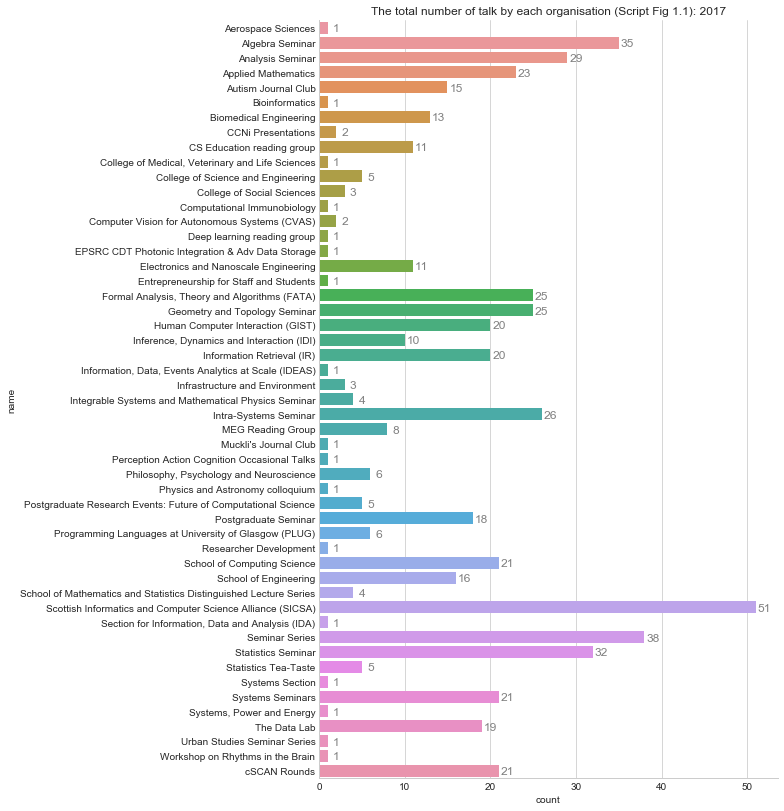

In [5]:
from matplotlib.pyplot import show
import seaborn as sns

#Sort plot in alphabetical order
data = talk_details.sort_values('name',ascending=True)

if data.empty:
    print('Datafram is empty')
else:
    #[1.1] Now let's plot the total number of talk by each organisation unit this academic year
    g = sns.factorplot( y="name" , data=data, kind="count", size=11, orient="h", legend_out ='Individual OU talks Count')
    plt.title("The total number of talk by each organisation (Script Fig 1.1): "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width() > 0:
            ax.text( 1+p.get_width(),p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center")


  

In [6]:
# [2] Access - Visualising the various types HTTP request sent by the users corresponding with the hour of the day, day and semester

#Import libaries required to perform analysis
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import json
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


from __future__ import division

In [7]:
# Let's check the total number of queries by general users/students/staff 
#(Access Table)


#We want to load the total number of queries by general users/students/staff from MYSQL database
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

search_details = pd.read_sql("SELECT id, remoteHost, userid, userName, status, referer, timestamp, query FROM access WHERE timestamp >="+"'"
                           +str(year_entered)+".09.01'"+ "AND" + " timestamp <="  +  "'" +str(year_entered+1)+ ".09.01';" , con=mysql_cn)   

#dframe = DataFrame(search_details)
#search_details.to_json('search_recent_allQuery1.json')
#with open('search_recent_allQuery1.json',encoding="utf8") as json_data:
    #search_details  = json.load(json_data )
dframe = DataFrame(search_details)

In [8]:
#Now let's display the search_details table
new_columns = ['remoteHost','id','userid','userName','timestamp','referer','query_type','query']

search_details = dframe.reindex(columns=new_columns)

search_details.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query
0,66.249.89.221,444182,,None,2017-09-01 00:05:11,None,NaN,/events/rest/Feed/user/b2dbd8077c98ed9c066601d...
1,66.249.89.223,444183,,None,2017-09-01 00:07:23,None,NaN,/events/rest/Feed/user/b5e888d795365b94678ef42...
2,130.209.253.174,444184,,None,2017-09-01 00:23:08,None,NaN,/events/rest/Feed/user/1809f978e0cfb3b31e9a2f7...
3,199.101.134.201,444185,,None,2017-09-01 00:23:09,None,NaN,/events/rest/Feed/rss/27
4,90.218.246.87,444186,,None,2017-09-01 00:25:12,None,NaN,/events/rest/Feed/user/1809f978e0cfb3b31e9a2f7...


In [9]:
#Create a method to indicate whether the user is a general user /student or non-student

def thestudents (usertype):
    try:
        thequery = usertype.str.split()
        for words in thequery:
            if words[0].isnumeric():
                return 'Registered User'
            if words[0].islower():
                return 'Registered User'
    except: 
        
        return "Not Known"

In [10]:
#Method to get days value in strings
def __str__(dateandtime):
    theday = str(dateandtime)
    theday = theday.replace("timestamp","")
    theday = theday[0:22]
    return str(theday)

In [11]:
#Add new column - Time_Series
search_details['user_status'] = search_details[['userid']].apply(thestudents,axis=1)
search_details['timestamp'] = search_details[['timestamp']].apply(__str__,axis=1)
search_details = search_details.sort_values(['userid'], ascending=[True])

search_details.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status
0,66.249.89.221,444182,,None,2017-09-01 00:05:11,None,NaN,/events/rest/Feed/user/b2dbd8077c98ed9c066601d...,Not Known
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,NaN,/events/fonts/glyphicons-halflings-regular.woff2,Not Known
453621,130.209.220.100,910873,,None,2018-03-26 12:49:09,None,NaN,/events/rest/Feed/user/b025b893324cba299dfbd73...,Not Known
453622,130.209.247.252,910874,,None,2018-03-26 12:49:45,None,NaN,/events/rest/Feed/user/bc1f55aad98bfbe0822fc9c...,Not Known
453623,172.30.170.235,910875,,None,2018-03-26 12:52:11,None,NaN,/events/rest/Feed/user/359b119f7ebf26eb2de33d8...,Not Known


In [12]:
#Create a method to to classify the query type

def thequery (query):
    try:
        thequery = query.str[0:]

        for words in thequery:
            if 'viewtalk'in words:
                return 'View Talk'
            elif 'index'in words:
                return 'Front Page'
            elif 'series'in words:
                return 'Series'
            elif 'search'in words:
                return 'Search'
            elif 'profile'in words:
                return 'Profile'
            elif 'help'in words:
                return 'Help'
            elif 'recent'in words:
                return 'Recent'
            elif 'myfeeds'in words:
                return 'My Feeds'
            elif 'upcoming.jsp'in words:
                return 'Marked Talk'
            elif 'login'in words:
                return 'Login'
            elif '/events'in words and len(words) < 10:
                return 'Front Page'
            elif 'group'in words:
                return 'Series'
            elif 'Feed'in words:
                return 'Feed Query'
            else:
                 return 'Others'
    except:
        return 'No URL'



In [13]:
#Create a method to to classify the feed query type from the others

def theCalendarQuery (query):
    try:
        thequery = query.str[0:]

        for words in thequery:
            if 'Feed'in words and 'user'in words:
                return 'User Feed'
            else:
                 return 'Not User Feed'
    except:
        return 'No URL'


In [14]:
#Column to classify query type and feed query type
search_details['query_type'] = search_details[['query']].apply(thequery,axis=1)

search_details['queryFeed_type'] = search_details[['query']].apply(theCalendarQuery,axis=1)

In [15]:
#Have a look at the dataframe

search_details.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
0,66.249.89.221,444182,,None,2017-09-01 00:05:11,None,Feed Query,/events/rest/Feed/user/b2dbd8077c98ed9c066601d...,Not Known,User Feed
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed
453621,130.209.220.100,910873,,None,2018-03-26 12:49:09,None,Feed Query,/events/rest/Feed/user/b025b893324cba299dfbd73...,Not Known,User Feed
453622,130.209.247.252,910874,,None,2018-03-26 12:49:45,None,Feed Query,/events/rest/Feed/user/bc1f55aad98bfbe0822fc9c...,Not Known,User Feed
453623,172.30.170.235,910875,,None,2018-03-26 12:52:11,None,Feed Query,/events/rest/Feed/user/359b119f7ebf26eb2de33d8...,Not Known,User Feed


#  I.P Usage check

In [16]:
# Let's carry out a quick I.P inspection

#We want to load the total number of queries by general users/students/staff from MYSQL database
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

ip_details = pd.read_sql("SELECT remoteHost, count(remoteHost)  FROM access WHERE timestamp >="+"'"
                           +str(year_entered)+".09.01'"+ "AND" + " timestamp <="  +  "'" +str(year_entered+1)+ ".09.01'" +"GROUP BY remoteHost ;" , con=mysql_cn)   


ip_details= DataFrame(ip_details)

ip_details = ip_details.sort_values(['count(remoteHost)'], ascending=[False])

ip_details = ip_details[ip_details['count(remoteHost)']>3000]

ip_details = ip_details[0:7]

ip_details.head()


,remoteHost,count(remoteHost)
4244,194.81.63.4,386044
472,130.209.220.100,57265
7726,82.26.64.185,24701
612,130.209.253.174,16353
590,130.209.247.252,13899


# Visualise I.Ps with really high usage activities

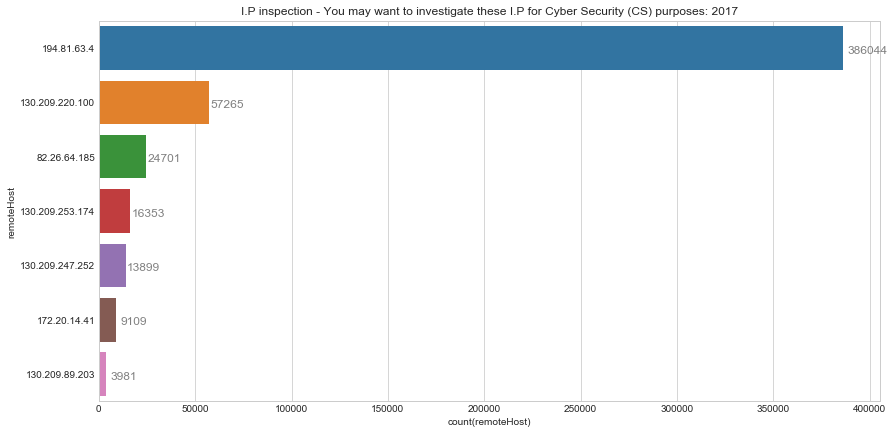

In [17]:
from matplotlib.pyplot import show
import seaborn as sns

plt.subplots(figsize=(14, 7))

plt.title("I.P inspection - You may want to investigate these I.P for Cyber Security (CS) purposes: "  +str(year_entered))

g = sns.barplot( x="count(remoteHost)" , y='remoteHost'  , data=ip_details)

# Get current axis on current figure
ax = plt.gca()


# Iterate through the list of axes' patches
for p in ax.patches:
    if p.get_width()> 0:
        ax.text( 9000+p.get_width()+p.get_width()*0.01,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
            fontsize=12, color='grey', ha='center', va="center", rotation="-0")
      
    


In [18]:
ip_details.head()

,remoteHost,count(remoteHost)
4244,194.81.63.4,386044
472,130.209.220.100,57265
7726,82.26.64.185,24701
612,130.209.253.174,16353
590,130.209.247.252,13899


# Enter any of the I.P above you want to investigate and see result in Section 11 below. Otherwise entered 0:

In [19]:
#Method to investigate I.P 
def ip_entered():
    process = True
    while process:
        try:
            ip = input("Please enter the I.P you want to investigate: ") 
            return ip
        except:
            print ("!!Invalid input data, please enter the right data")

#Enter year now
ip_entered = ip_entered()

ip_entered

Please enter the I.P you want to investigate: 194.81.63.4


'194.81.63.4'

In [20]:
#Let's filter the unreal queries from real queries 
#Enter year now
ip_entered = str(ip_entered)

intruder = search_details[search_details["remoteHost"].str.contains(ip_entered)==True] 

intruder  = intruder [intruder ["query_type"].str.contains('No URL')==False]

intruder = intruder [intruder ["query_type"].str.contains('Feed Query')==False]

intruder.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
448318,194.81.63.4,905531,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448319,194.81.63.4,905532,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448320,194.81.63.4,905533,,None,2018-03-23 22:14:56,None,Front Page,/events/,Not Known,Not User Feed
448321,194.81.63.4,905534,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448322,194.81.63.4,905535,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed


In [21]:
#Let's check for user using their calendars

calendar_check = search_details[search_details["queryFeed_type"].str.contains('User Feed')==True]

calendar_check.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
0,66.249.89.221,444182,,None,2017-09-01 00:05:11,None,Feed Query,/events/rest/Feed/user/b2dbd8077c98ed9c066601d...,Not Known,User Feed
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed
453621,130.209.220.100,910873,,None,2018-03-26 12:49:09,None,Feed Query,/events/rest/Feed/user/b025b893324cba299dfbd73...,Not Known,User Feed
453622,130.209.247.252,910874,,None,2018-03-26 12:49:45,None,Feed Query,/events/rest/Feed/user/bc1f55aad98bfbe0822fc9c...,Not Known,User Feed
453623,172.30.170.235,910875,,None,2018-03-26 12:52:11,None,Feed Query,/events/rest/Feed/user/359b119f7ebf26eb2de33d8...,Not Known,User Feed


In [22]:
#Let's filter the information we want

search_details = search_details[search_details["remoteHost"].str.contains(ip_entered)==False] 

search_details = search_details[search_details["query_type"].str.contains('No URL')==False]

search_details = search_details[search_details["query_type"].str.contains('Feed Query')==False]


In [23]:
search_details.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed
453619,192.41.131.251,910871,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/,Search,/events/rest/Event/searchtext,Not Known,Not User Feed
453627,65.49.2.182,910879,,None,2018-03-26 12:54:38,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed
453618,192.41.131.251,910869,,None,2018-03-26 12:47:46,None,Front Page,/events/,Not Known,Not User Feed
453636,172.30.170.235,910888,,None,2018-03-26 13:01:13,None,Front Page,/events/,Not Known,Not User Feed


In [24]:
intruder.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
448318,194.81.63.4,905531,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448319,194.81.63.4,905532,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448320,194.81.63.4,905533,,None,2018-03-23 22:14:56,None,Front Page,/events/,Not Known,Not User Feed
448321,194.81.63.4,905534,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448322,194.81.63.4,905535,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed


In [25]:
#Import date library

import datetime
from datetime import datetime, timedelta

#So let's split and parse the day and time to visualise query distribution in days and in time

#method to return actual date values
def days_Value (dateandtime):

    #dateandtime = str(dateandtime)
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    return days 

    #method to return actual hour values
def hours_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    hour = int(theday[0][2][3:5])
      
    return hour



    #method to return hours time group
def hourlabel_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    
    hour = int(theday[0][2][3:5])
    

    if hour >= 0 and hour <= 5:
        return '0-5am'
    elif hour >=6 and hour <=10:
        return "6-10am"
    elif hour >=11 and hour <=14:
        return "11am-2pm"
    elif hour >=15 and hour <=18:
        return "3pm-6pm"
    elif hour >=18 and hour <=24:
        return "6pm-12am"
    
    return hour

    #method to return actual month values
def months_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
   
    month = int(theday[0][1])
        
    return month

#Method to get number of days and days description string
def defineDays (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    if days < 0:
        return ''
    elif days == 0:
        return "within 24 hours" 
    elif days > 0 and days < 7:
        return '1 to 7 days ago'
    elif days >=7 and days <30:
        return "7 to 30 days ago"
    elif days >=30 and days <60:
        return "1 to 2 months ago"
    elif days >=60 and days <120:
        return "2 to 4 months ago"
    elif days >=120 and days <180:
        return "4 to 6 months ago"
    elif days >=180 and days <365:
        return "6months to 1 year ago"

    #Method to get number of days and days description string
def semester (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
   
    month = int(theday[0][1])
    
    if month < 0:
        return ''
    elif month >=9 and month <= 12:
        return 'Semester 1'
    elif month >=1 and month <=4:
        return "Semester 2"
    elif month >=5 and month <=8:
        return "Semester 3"

In [26]:
#Column to show specific semester, day and time of the day
search_details['days_value'] = search_details[['timestamp']].apply(days_Value,axis=1)

search_details['month_value'] = search_details[['timestamp']].apply(months_Value,axis=1)

search_details['hour of the day'] = search_details[['timestamp']].apply(hours_Value,axis=1)

search_details['hour label'] = search_details[['timestamp']].apply(hourlabel_Value,axis=1)

search_details['period'] = search_details[['timestamp']].apply(defineDays,axis=1)

search_details['School Session'] = search_details[['timestamp']].apply(semester,axis=1)

search_details.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,days_value,month_value,hour of the day,hour label,period,School Session
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453619,192.41.131.251,910871,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/,Search,/events/rest/Event/searchtext,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453627,65.49.2.182,910879,,None,2018-03-26 12:54:38,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453618,192.41.131.251,910869,,None,2018-03-26 12:47:46,None,Front Page,/events/,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453636,172.30.170.235,910888,,None,2018-03-26 13:01:13,None,Front Page,/events/,Not Known,Not User Feed,156,3,13,11am-2pm,4 to 6 months ago,Semester 2


In [27]:
search_details.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,days_value,month_value,hour of the day,hour label,period,School Session
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453619,192.41.131.251,910871,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/,Search,/events/rest/Event/searchtext,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453627,65.49.2.182,910879,,None,2018-03-26 12:54:38,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453618,192.41.131.251,910869,,None,2018-03-26 12:47:46,None,Front Page,/events/,Not Known,Not User Feed,156,3,12,11am-2pm,4 to 6 months ago,Semester 2
453636,172.30.170.235,910888,,None,2018-03-26 13:01:13,None,Front Page,/events/,Not Known,Not User Feed,156,3,13,11am-2pm,4 to 6 months ago,Semester 2


In [28]:
search0_details = search_details[search_details["query_type"].str.contains('Others')==False]

search0_details = search0_details.sort_values(['timestamp'], ascending=[True])

#  [2.1] The total number of queries per semester this academic year 

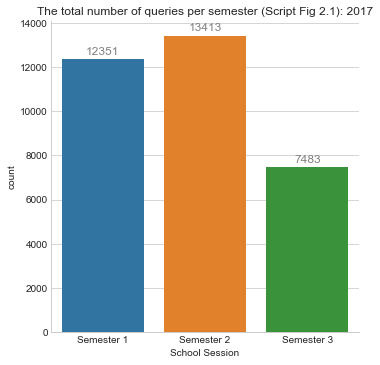

In [29]:
# [2.1] The total number of queries per semester this academic year 
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" , 
                   data=search0_details, kind="count", size=5, )
    plt.title("The total number of queries per semester (Script Fig 2.1): "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')



# [2.2] The types of query request this academic year 

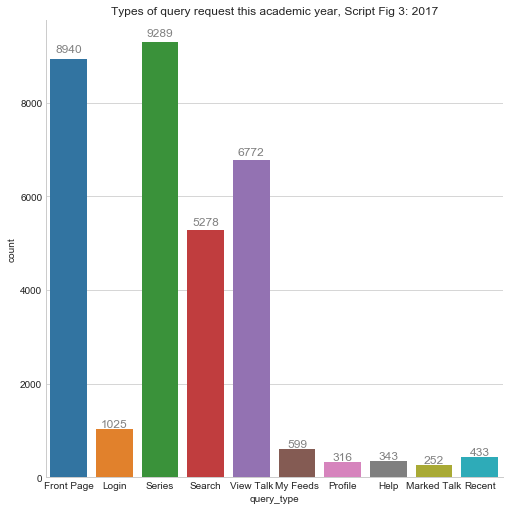

In [30]:
#2.2) The types of query request this academic year 
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="query_type" , 
                       data=search0_details, kind="count", size=7
                      )
    plt.title("Types of query request this academic year, Script Fig 3: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    #plt.ticks(rotation=89)

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')
    





# [2.3] The types of queries request per semester this academic year

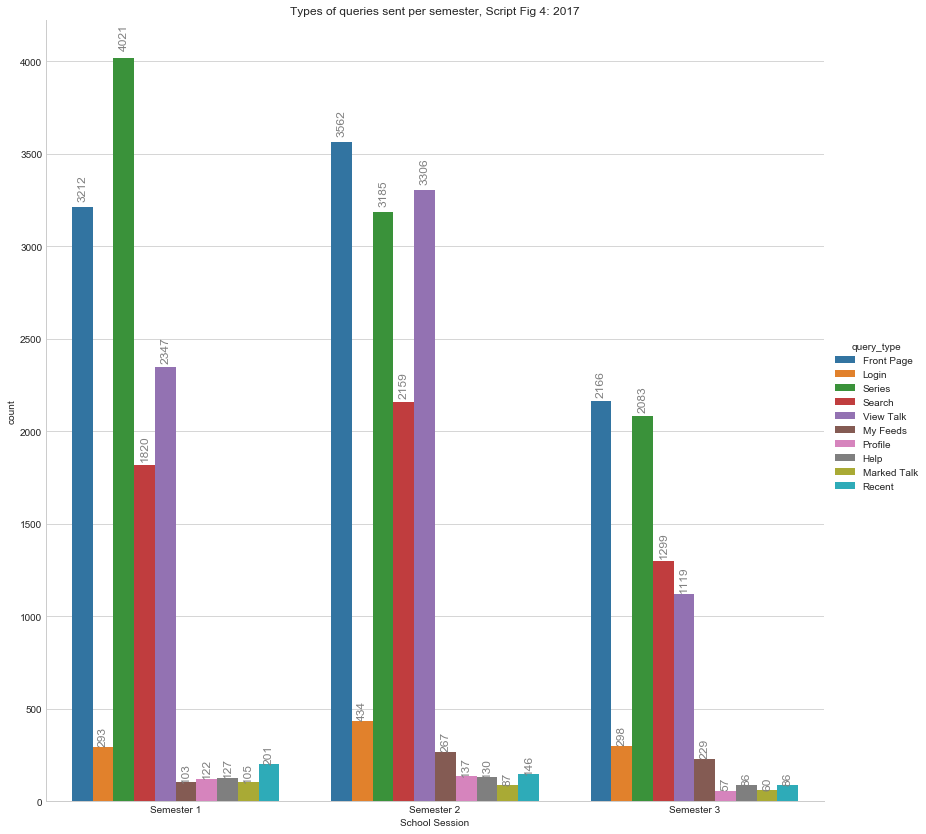

In [31]:
# [2.3] The types of queries request per semester this academic year
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" , 
                       data=search0_details, kind="count", size=11.5, hue='query_type')


    plt.title("Types of queries sent per semester, Script Fig 4: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+ p.get_height() * 0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom', rotation='90')


# [2.4] The types of queries sent for every month this academic year 

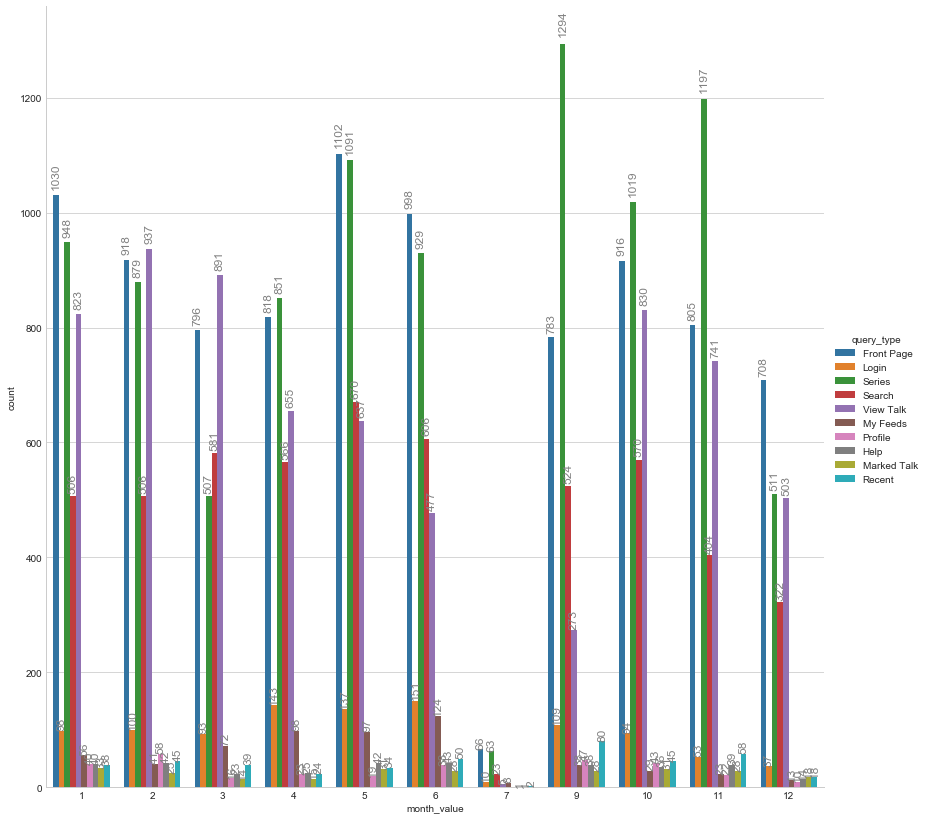

In [32]:
# [2.4] The types of queries sent for every month this academic year 
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="month_value" , 
                       data=search0_details, kind="count", size=11.5, hue='query_type')
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+ p.get_height() * 0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom', rotation='90')



# [2.5] The total number of user interaction for every hour of the day this academic year

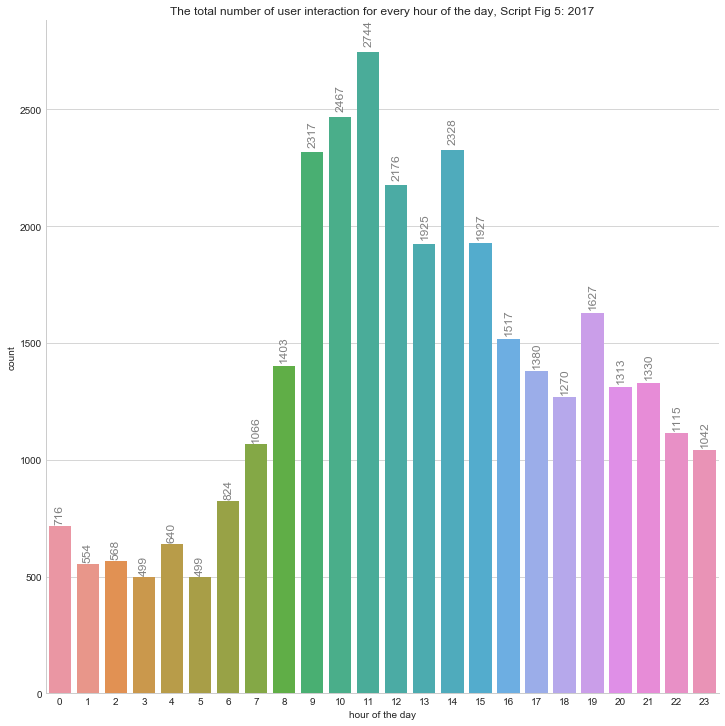

In [33]:
# [2.5] The total number of user interaction for every hour of the day this academic year
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="hour of the day" , 
                       data=search0_details, kind="count", size=10)

    plt.title("The total number of user interaction for every hour of the day, Script Fig 5: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom', rotation="90")

# [2.6] The types of query in a specific time group of the day this academic year 

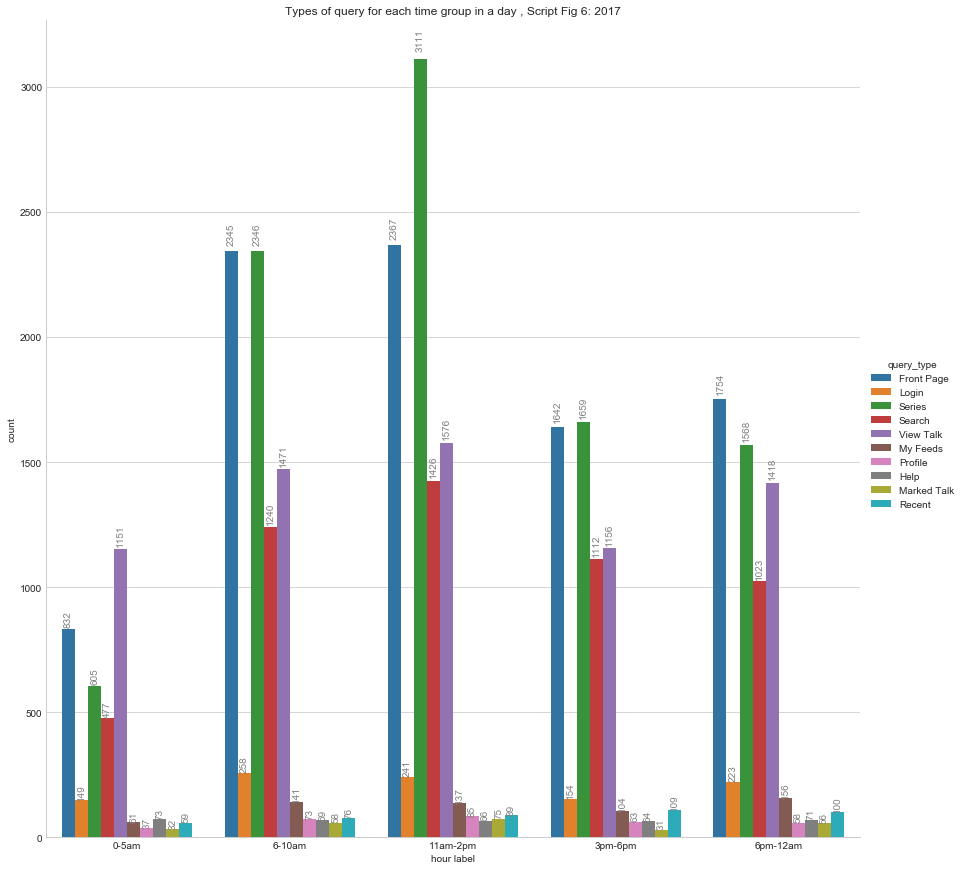

In [34]:
# [2.6] The types of query in a specific time group of the day this academic year
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="hour label" , 
                       data=search0_details, kind="count", size=12, hue='query_type')

    plt.title("Types of query for each time group in a day , Script Fig 6: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=10, color='grey', ha='center', va='bottom', rotation='90')


In [35]:
#GOD IS EXCELLENT

data=search0_details[(search0_details['query_type'] == "View Talk") | (search0_details['query_type'] == "Search") | (search0_details['query_type'] == "Help")]

data = data.sort_values('hour of the day',ascending=True)

data.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,days_value,month_value,hour of the day,hour label,period,School Session
80030,52.51.64.142,530572,,None,2017-10-09 00:31:39,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,325,10,0,0-5am,6months to 1 year ago,Semester 1
80016,52.51.64.142,530558,,None,2017-10-09 00:31:27,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,325,10,0,0-5am,6months to 1 year ago,Semester 1
80017,52.51.64.142,530559,,None,2017-10-09 00:31:28,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,325,10,0,0-5am,6months to 1 year ago,Semester 1
80018,52.51.64.142,530560,,None,2017-10-09 00:31:28,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,325,10,0,0-5am,6months to 1 year ago,Semester 1
80019,52.51.64.142,530561,,None,2017-10-09 00:31:29,None,View Talk,/events/viewtalk.jsp,Not Known,Not User Feed,325,10,0,0-5am,6months to 1 year ago,Semester 1


# [2.7] The comparison of the view talk, help and search queries this academic year

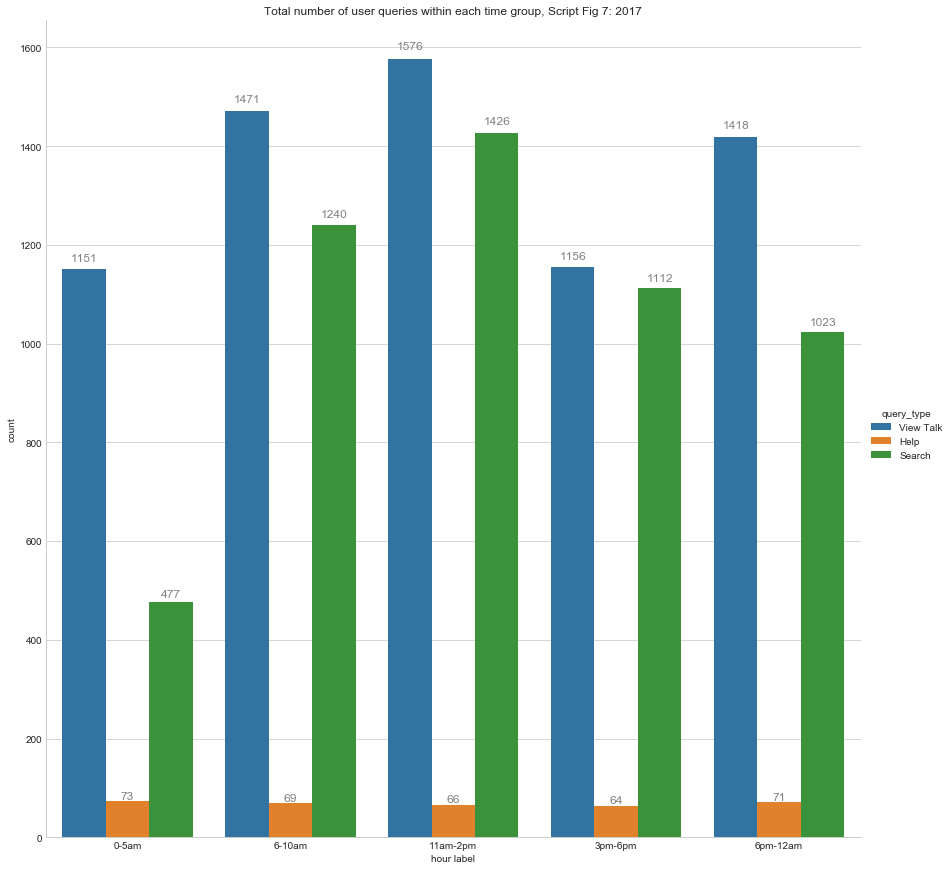

In [36]:
# [2.7] The comparison of the view talk, help and search queries this academic year
if data.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="hour label" , 
                       data=data ,kind="count", size=12, hue="query_type")


    plt.title("Total number of user queries within each time group, Script Fig 7: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

        



In [37]:
#GOD IS EXCELLENT

data=search_details[(search_details['query_type'] == "Others")]

dataOther = data.sort_values('hour of the day',ascending=True)

dataOther.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,days_value,month_value,hour of the day,hour label,period,School Session
384703,5.65.22.86,841235,,None,2018-02-24 00:33:22,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,Others,/events/rest/Event/8375,Not Known,Not User Feed,187,2,0,0-5am,6months to 1 year ago,Semester 2
235951,81.97.32.255,690513,,None,2017-12-08 00:41:00,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,Others,/events/rest/Group/getsubscribercount/7,Not Known,Not User Feed,265,12,0,0-5am,6months to 1 year ago,Semester 1
414513,82.28.11.175,871305,,None,2018-03-05 00:02:59,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,Others,/events/rest/User/Rwms1u/getupcomingids,Not Known,Not User Feed,178,3,0,0-5am,4 to 6 months ago,Semester 2
235952,81.97.32.255,690514,,None,2017-12-08 00:41:05,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,Others,/events/rest/Event/8446,Not Known,Not User Feed,265,12,0,0-5am,6months to 1 year ago,Semester 1
523558,66.249.76.130,981817,,None,2018-05-03 00:40:10,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,Others,/events/rest/Group/getsubscribercount/111,Not Known,Not User Feed,119,5,0,0-5am,2 to 4 months ago,Semester 3


In [38]:
#Create a method to to classify the query type

def theotherqueries (query):

    thequery = query.str[0:]
        
    for words in thequery:
        if '/subscribe/'in words:
            return 'Subscribe Query'
        elif '/unsubscribe/'in words:
            return 'Unsubscribe Query'
        elif 'glyphicons'in words:
            return 'Glyphicons Query'
        elif 'getmarkedreminder'in words:
            return 'Reminder Query'
        else:
             return 'all other queries'

In [39]:
#Column to classify query type

dataOther['query_type'] = dataOther[['query']].apply(theotherqueries,axis=1)

dataOther = dataOther[(dataOther['query_type'] == "Calendar Query")| (dataOther['query_type'] == "Profile Query") |(dataOther['query_type'] == "Subscribe Query") | (dataOther['query_type'] == "Unsubscribe Query") | (dataOther['query_type'] == "Reminder Query")]

dataOther.head()



,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,days_value,month_value,hour of the day,hour label,period,School Session
80111,94.197.120.6,530655,,None,2017-10-09 06:14:50,https://samoa.dcs.gla.ac.uk/events/profile.jsp,Reminder Query,/events/rest/User/ncc5t/getmarkedreminderstate,Not Known,Not User Feed,324,10,6,6-10am,6months to 1 year ago,Semester 1
523865,82.24.36.113,982128,190,None,2018-05-03 06:12:40,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,Subscribe Query,/events/rest/User/2146879D/subscribe/68,Registered User,Not User Feed,118,5,6,6-10am,2 to 4 months ago,Semester 3
631940,130.209.252.92,1091322,204,None,2018-06-15 07:55:04,https://samoa.dcs.gla.ac.uk/events/profile.jsp,Reminder Query,/events/rest/User/mjb24v/getmarkedreminderstate,Registered User,Not User Feed,75,6,7,6-10am,2 to 4 months ago,Semester 3
77838,172.30.189.59,528108,179,None,2017-10-04 08:36:54,https://samoa.dcs.gla.ac.uk/events/profile.jsp,Subscribe Query,/events/rest/User/2332462H/subscribe/2,Registered User,Not User Feed,329,10,8,6-10am,6months to 1 year ago,Semester 1
77895,172.30.189.59,528169,179,None,2017-10-04 08:57:21,https://samoa.dcs.gla.ac.uk/events/profile.jsp,Subscribe Query,/events/rest/User/2332462H/subscribe/11,Registered User,Not User Feed,329,10,8,6-10am,6months to 1 year ago,Semester 1


# [2.8] The comparison of the subscribe, reminder and unsubscribe queries this academic year

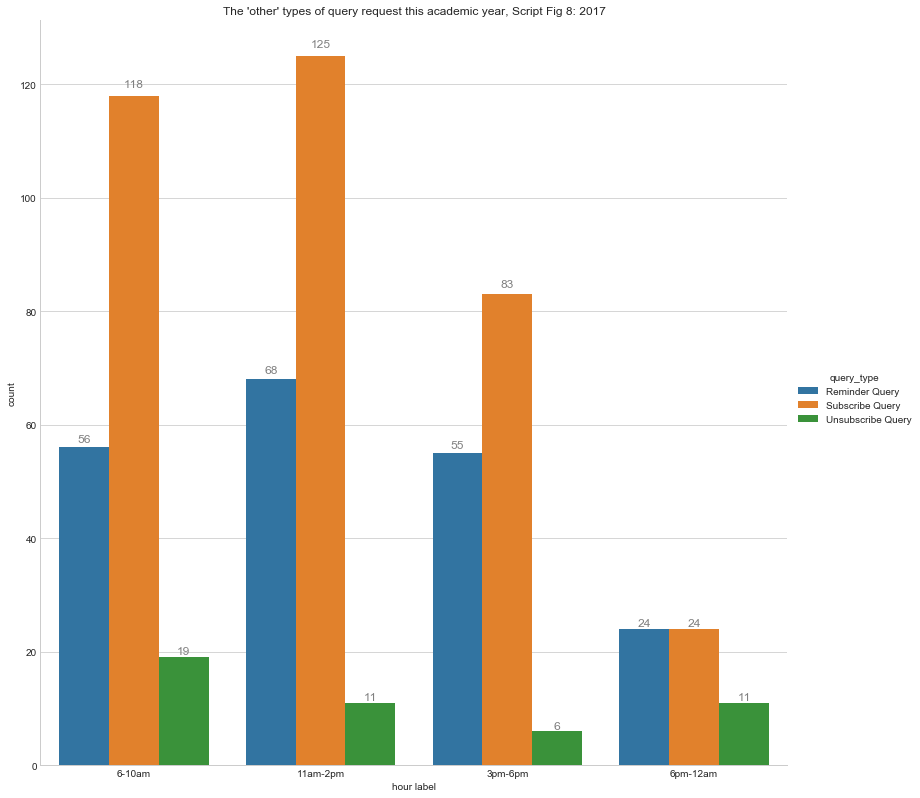

In [40]:
# [2.8] The comparison of the subscribe, reminder and unsubscribe queries this academic year 
if dataOther.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="hour label" , 
                       data=dataOther, kind="count", size=11, hue = "query_type")

    plt.title("The 'other' types of query request this academic year, Script Fig 8: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')


# [2.9] The total number of queries by user types this academic year

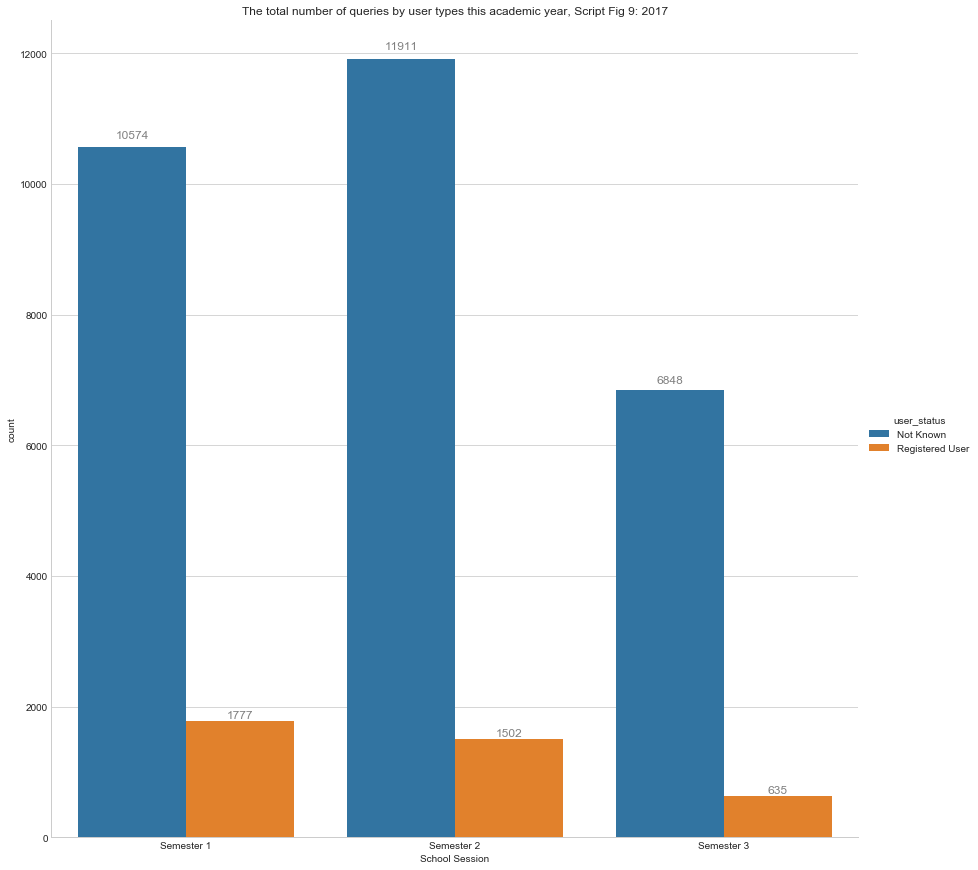

In [41]:
# [2.9] The total number of queries by user types this academic year
if search0_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" , 
                       data=search0_details, kind="count", size=12, hue ="user_status")

    plt.title("The total number of queries by user types this academic year, Script Fig 9: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')


In [42]:
# Talk Interaction - Visualising the what talks the user interacts with and what kind of interaction with corresponding hour of the day, day and semester.

#We want to load the total number of queries by general users/students/staff from MYSQL database
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

talk_details = pd.read_sql("SELECT T.title,TI.datetime,  U.email, TI.interaction  FROM talksdb_copy.users AS U INNER JOIN talkinteractions AS TI on U.id = TI.userid  INNER JOIN talksdb_copy.talks AS T on T.id =TI.talkid WHERE TI.datetime  >="+"'"
                           +str(year_entered)+".09.01'"+ "AND" + " datetime <="  +  "'" +str(year_entered+1)+ ".09.01';", con=mysql_cn)   

#Now let's open the talk_details in a dataFrame

dframe = DataFrame(talk_details)

dframe.head()

,title,datetime,email,interaction
0,From Hopf Algebras to Machine learning via Rou...,2017-09-04 07:40:49,Simon.Rogers@glasgow.ac.uk,mark
1,Introducing Nature Human Behaviour,2017-09-10 21:30:32,Roderick.Murray-Smith@glasgow.ac.uk,mark
2,A Theory of How People Make Decisions Through ...,2017-09-11 11:11:22,Andrew.Ramsay@glasgow.ac.uk,mark
3,A Theory of How People Make Decisions Through ...,2017-09-11 11:11:25,Andrew.Ramsay@glasgow.ac.uk,unmark
4,Amplifying Human Abilities: Digital Technologi...,2017-09-11 12:46:52,Roderick.Murray-Smith@glasgow.ac.uk,talkClicked


In [43]:
#Create a method to indicate whether user is student or non-student

def students (usertype):

    person = usertype.str.split('@')
    person = person[0][1][0:]
    
    for words in  person:
        if words in 'student':
            return 'Student'
        elif words in 'research':
            return 'Research Student'
        else:
             return 'Staff'

In [44]:
#Method to get days value in strings
def __str__(dateandtime):
    theday = str(dateandtime)
    theday = theday.replace("datetime","")
    theday = theday[0:22]
    return theday

#Add new column - Time_Series
dframe['datetime'] = dframe[['datetime']].apply(__str__,axis=1)

talk_details = dframe

talk_details.head()

,title,datetime,email,interaction
0,From Hopf Algebras to Machine learning via Rou...,2017-09-04 07:40:49,Simon.Rogers@glasgow.ac.uk,mark
1,Introducing Nature Human Behaviour,2017-09-10 21:30:32,Roderick.Murray-Smith@glasgow.ac.uk,mark
2,A Theory of How People Make Decisions Through ...,2017-09-11 11:11:22,Andrew.Ramsay@glasgow.ac.uk,mark
3,A Theory of How People Make Decisions Through ...,2017-09-11 11:11:25,Andrew.Ramsay@glasgow.ac.uk,unmark
4,Amplifying Human Abilities: Digital Technologi...,2017-09-11 12:46:52,Roderick.Murray-Smith@glasgow.ac.uk,talkClicked


In [45]:
#Import the date and time library
import datetime
from datetime import datetime, timedelta


#Method to get days value in strings
def __str__(dateandtime):

    #dateandtime = str(dateandtime)
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    if days >= 0:
        return ' ('+str(days) + ' days ago'+')'
 
    
#method to return actual date values
def days_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    return days 

    #Method to get number of days and days description string
def semester (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
   
    month = int(theday[0][1])
    
    if month < 0:
        return ''
    elif month >=9 and month <= 12:
        return 'Semester 1'
    elif month >=1 and month <=4:
        return "Semester 2"
    elif month >=5 and month <=8:
        return "Semester 3"

In [46]:
#Now let's display the talk_details table
new_columns = ['title','interaction','user_type','email','datetime', 'when', 'titlewhen']
talk_details = dframe.reindex(columns=new_columns)

#Add new column - Time_Series
talk_details['when'] = talk_details[['datetime']].apply(__str__,axis=1)

#Add new column - days_Value
talk_details['days_Value'] = talk_details[['datetime']].apply(days_Value,axis=1)

#Add new column - student
talk_details['user_type'] = talk_details[['email']].apply(students,axis=1)

#Add new column - student
talk_details['School Session'] = talk_details[['datetime']].apply(semester,axis=1)

talk_details1 = talk_details

#View the first 5 rows
talk_details1.head()

,title,interaction,user_type,email,datetime,when,titlewhen,days_Value,School Session
0,From Hopf Algebras to Machine learning via Rou...,mark,Staff,Simon.Rogers@glasgow.ac.uk,2017-09-04 07:40:49,(359 days ago),NaN,359,Semester 1
1,Introducing Nature Human Behaviour,mark,Staff,Roderick.Murray-Smith@glasgow.ac.uk,2017-09-10 21:30:32,(353 days ago),NaN,353,Semester 1
2,A Theory of How People Make Decisions Through ...,mark,Staff,Andrew.Ramsay@glasgow.ac.uk,2017-09-11 11:11:22,(352 days ago),NaN,352,Semester 1
3,A Theory of How People Make Decisions Through ...,unmark,Staff,Andrew.Ramsay@glasgow.ac.uk,2017-09-11 11:11:25,(352 days ago),NaN,352,Semester 1
4,Amplifying Human Abilities: Digital Technologi...,talkClicked,Staff,Roderick.Murray-Smith@glasgow.ac.uk,2017-09-11 12:46:52,(352 days ago),NaN,352,Semester 1


In [47]:
#Add new column - Time_Series
talk_details1['titlewhen'] =  talk_details['title'] +talk_details['when']

#View the first 5 rows
talk_details1.head()

,title,interaction,user_type,email,datetime,when,titlewhen,days_Value,School Session
0,From Hopf Algebras to Machine learning via Rou...,mark,Staff,Simon.Rogers@glasgow.ac.uk,2017-09-04 07:40:49,(359 days ago),From Hopf Algebras to Machine learning via Rou...,359,Semester 1
1,Introducing Nature Human Behaviour,mark,Staff,Roderick.Murray-Smith@glasgow.ac.uk,2017-09-10 21:30:32,(353 days ago),Introducing Nature Human Behaviour (353 days ago),353,Semester 1
2,A Theory of How People Make Decisions Through ...,mark,Staff,Andrew.Ramsay@glasgow.ac.uk,2017-09-11 11:11:22,(352 days ago),A Theory of How People Make Decisions Through ...,352,Semester 1
3,A Theory of How People Make Decisions Through ...,unmark,Staff,Andrew.Ramsay@glasgow.ac.uk,2017-09-11 11:11:25,(352 days ago),A Theory of How People Make Decisions Through ...,352,Semester 1
4,Amplifying Human Abilities: Digital Technologi...,talkClicked,Staff,Roderick.Murray-Smith@glasgow.ac.uk,2017-09-11 12:46:52,(352 days ago),Amplifying Human Abilities: Digital Technologi...,352,Semester 1


# [3] The total number of talk per semester this academic year

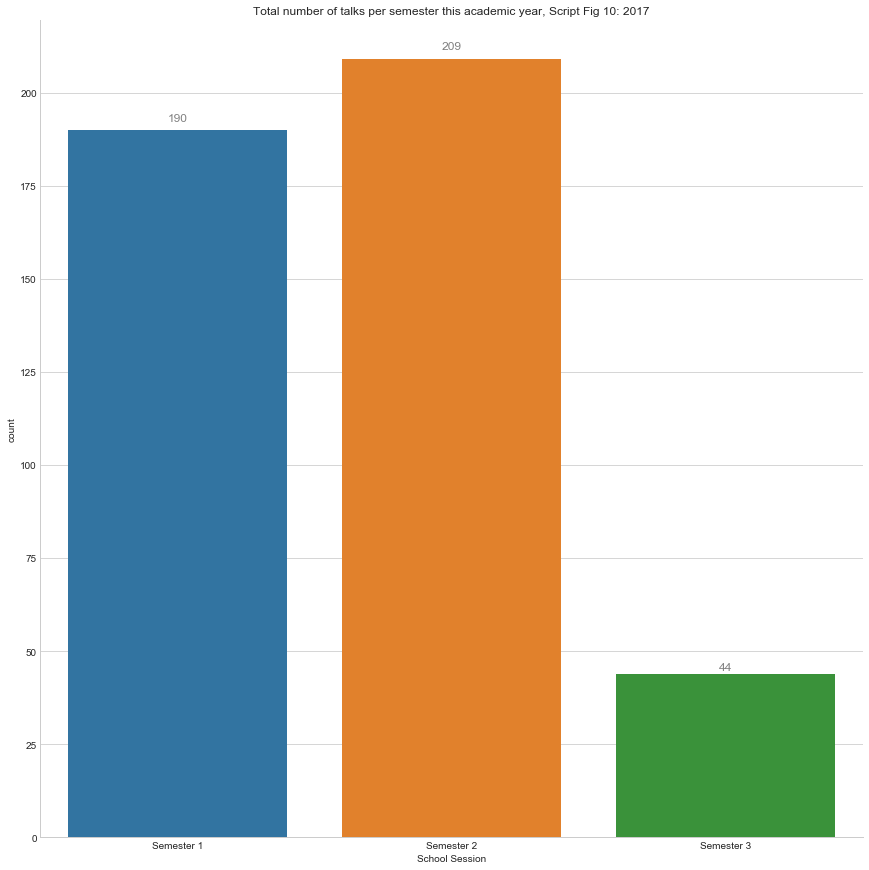

In [48]:
#[3] Let's check the total number of talk per semester this academic year
if talk_details1.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" ,
                       data=talk_details1, kind="count", size=12 )

    plt.title("Total number of talks per semester this academic year, Script Fig 10: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [3.1] The total number of talk interaction by logged users per semester this academic year

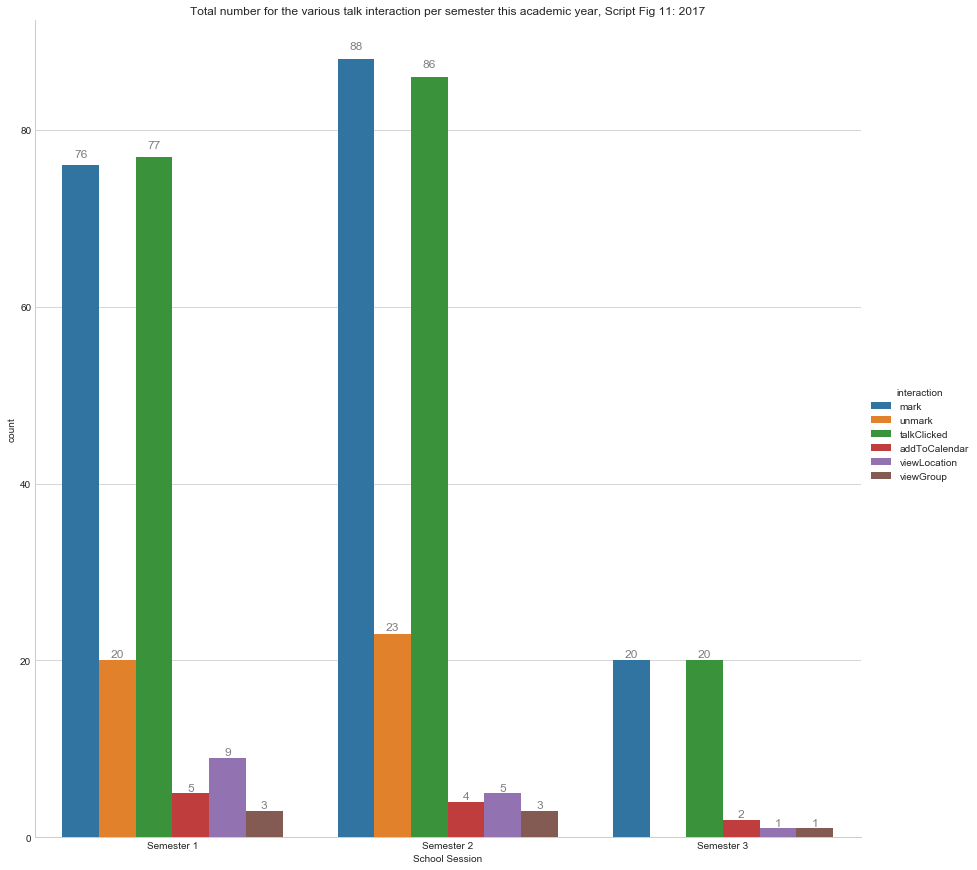

In [49]:
# [3.1] The total number of talk interaction by logged users per semester this academic year
if talk_details1.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" ,
                       data=talk_details1, kind="count", size=12, hue='interaction' )

    plt.title("Total number for the various talk interaction per semester this academic year, Script Fig 11: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')


# [3.2] Total number of interaction by logged-in users on talks this semester 3

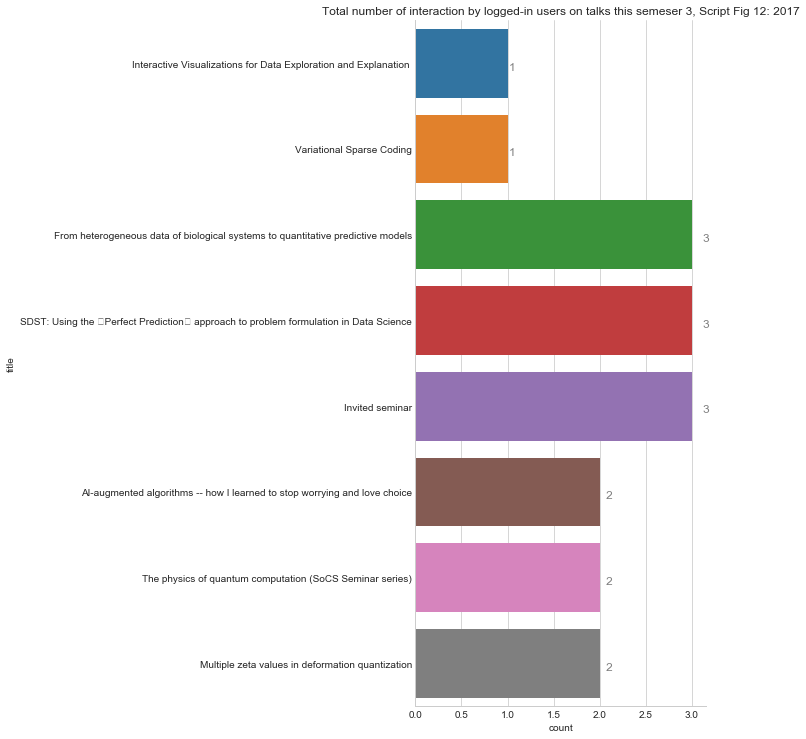

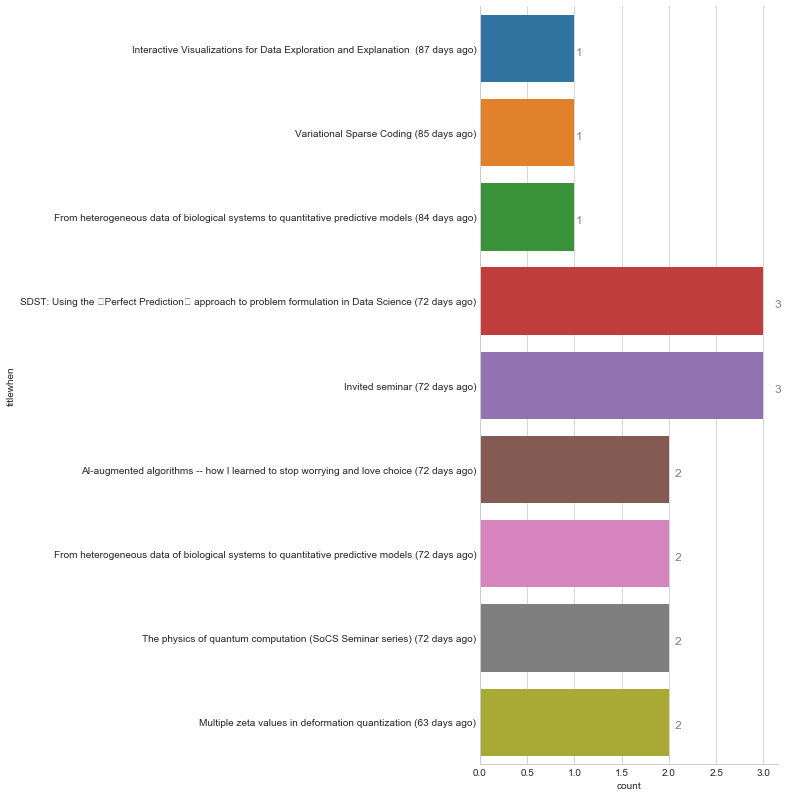

In [50]:
# [3.2] Now let's plot the total number of interaction by logged-in users on talks this semester 3
data=talk_details1
interaction_data = data [data ["days_Value"]<=90]
if interaction_data.empty:
    interaction_data = data [data ["days_Value"]<=180]
if interaction_data.empty:
    interaction_data = data [data ["days_Value"]<=365]
if interaction_data.empty:
    print('DataFrame is empty')
else:    
    #Let sort the chart data in alphabetical order
    data =talk_details1.sort_values('title',ascending=True)
    g = sns.factorplot( y="title" ,data=interaction_data, kind="count", size=10 )
    plt.title("Total number of interaction by logged-in users on talks this semeser 3, Script Fig 12: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width() > 0:
            ax.text( p.get_width()+p.get_width()*0.05,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center")


    #Let sort the chart data in alphabetical order
    data =talk_details1.sort_values('titlewhen',ascending=True)

    g = sns.factorplot( y="titlewhen" ,
                       data=interaction_data, kind="count", size= 11)

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width() > 0:
            ax.text( p.get_width()+p.get_width()*0.05,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center")

In [51]:
#Add new column - Time_Series
talk_details1['titlewhen'] = talk_details1['title'] +' '+talk_details1['when'] 

#View the first 5 rows
talk_details1.head()

,title,interaction,user_type,email,datetime,when,titlewhen,days_Value,School Session
0,From Hopf Algebras to Machine learning via Rou...,mark,Staff,Simon.Rogers@glasgow.ac.uk,2017-09-04 07:40:49,(359 days ago),From Hopf Algebras to Machine learning via Rou...,359,Semester 1
1,Introducing Nature Human Behaviour,mark,Staff,Roderick.Murray-Smith@glasgow.ac.uk,2017-09-10 21:30:32,(353 days ago),Introducing Nature Human Behaviour (353 days ...,353,Semester 1
2,A Theory of How People Make Decisions Through ...,mark,Staff,Andrew.Ramsay@glasgow.ac.uk,2017-09-11 11:11:22,(352 days ago),A Theory of How People Make Decisions Through ...,352,Semester 1
3,A Theory of How People Make Decisions Through ...,unmark,Staff,Andrew.Ramsay@glasgow.ac.uk,2017-09-11 11:11:25,(352 days ago),A Theory of How People Make Decisions Through ...,352,Semester 1
4,Amplifying Human Abilities: Digital Technologi...,talkClicked,Staff,Roderick.Murray-Smith@glasgow.ac.uk,2017-09-11 12:46:52,(352 days ago),Amplifying Human Abilities: Digital Technologi...,352,Semester 1


# [3.3] Semester comparison of user talk interaction per  user type

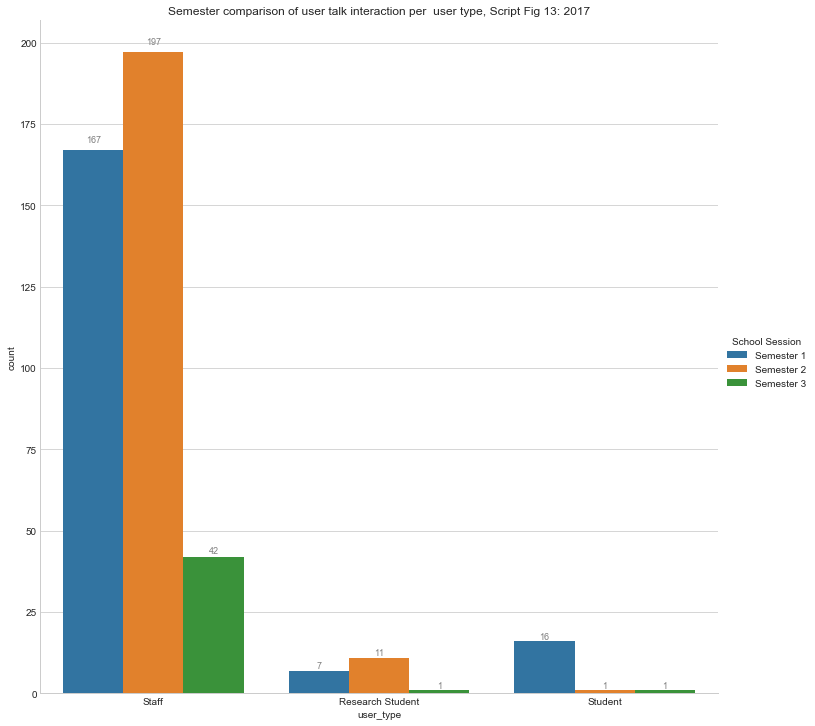

In [52]:
# [3.3] Now let's display the Semester comparison of user talk interaction per  user type
if talk_details1.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="user_type" , 
                       data=talk_details1, kind="count", hue="School Session", size=10)

    plt.title("Semester comparison of user talk interaction per  user type, Script Fig 13: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=9, color='grey', ha='center', va='bottom')

# [3.4]  List of daily interactions by registered users this academic year

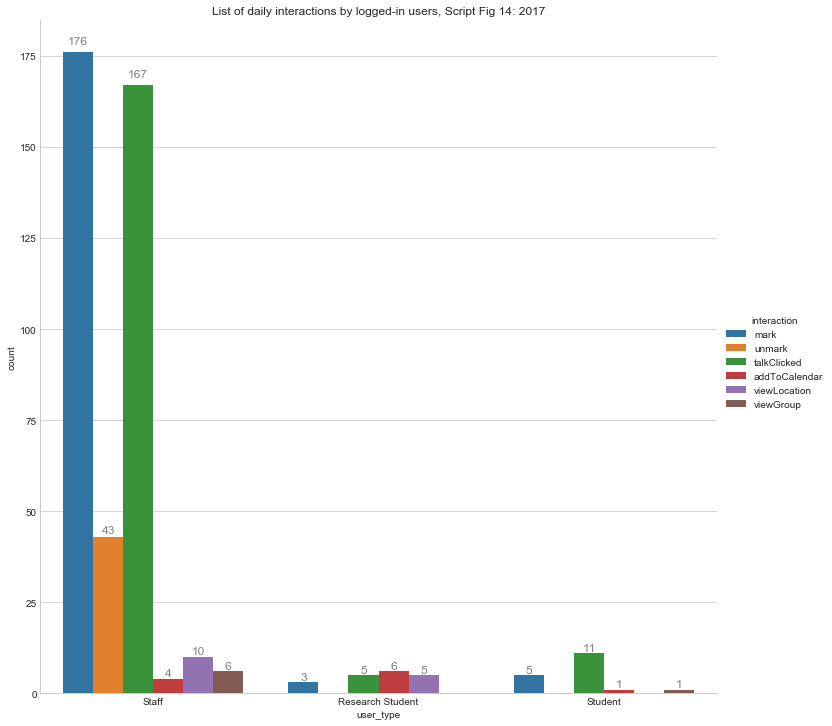

In [53]:
# [3.4] Now let's plot the list of daily interactions by registered users this academic year

if talk_details1.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="user_type" , 
                       data=talk_details1, kind="count", size=10, hue="interaction")


    plt.title("List of daily interactions by logged-in users, Script Fig 14: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

In [54]:
#Series Interaction - Visualising which organisational group the users subscribe to, including the time, day and semester at which this subscriptions took place.

#Now let's look into the series subscription 

#We want to load the  SQL data for series, organisational group and user  from MYSQL database
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

series_details = pd.read_sql("SELECT  U.email, OU.name,  datetime, interaction FROM talksdb_copy.users AS U INNER JOIN  seriesinteractions AS SI ON U.id = SI.userid INNER JOIN talksdb_copy.organisationalUnits AS OU ON OU.id = SI.seriesid WHERE datetime >="+"'"
                           +str(year_entered)+".09.01'"+ "AND" + " datetime <="  +  "'" +str(year_entered+1)+ ".09.01';", con=mysql_cn)   

#Now let open the series_details in dataFrame
dframe1 = DataFrame(series_details)

dframe1.head()

,email,name,datetime,interaction
0,Linsey.Robertson@glasgow.ac.uk,Researcher Development,2017-09-01 15:52:40,subscribe
1,Roderick.Murray-Smith@glasgow.ac.uk,Decision Making Journal Club,2017-09-10 21:27:31,subscribe
2,Roderick.Murray-Smith@glasgow.ac.uk,Autism Journal Club,2017-09-10 21:27:59,subscribe
3,Roderick.Murray-Smith@glasgow.ac.uk,Social Events,2017-09-10 21:28:24,subscribe
4,Roderick.Murray-Smith@glasgow.ac.uk,CCNi Presentations,2017-09-10 21:28:51,subscribe


In [55]:
#Now let's display the series_details table

new_columns = ['name','datetime','email','interaction']

series_details = dframe1.reindex(columns=new_columns)

series_details.head()

,name,datetime,email,interaction
0,Researcher Development,2017-09-01 15:52:40,Linsey.Robertson@glasgow.ac.uk,subscribe
1,Decision Making Journal Club,2017-09-10 21:27:31,Roderick.Murray-Smith@glasgow.ac.uk,subscribe
2,Autism Journal Club,2017-09-10 21:27:59,Roderick.Murray-Smith@glasgow.ac.uk,subscribe
3,Social Events,2017-09-10 21:28:24,Roderick.Murray-Smith@glasgow.ac.uk,subscribe
4,CCNi Presentations,2017-09-10 21:28:51,Roderick.Murray-Smith@glasgow.ac.uk,subscribe


In [56]:
#Write out a method to check for students
def students (usertype):

    person = usertype.str.split('@')
    person = person[0][1][0:]
    
    for words in  person:
        if words in 'student':
            return 'Student'
        elif words in 'research':
            return 'Research Student'
        else:
             return 'Staff'

In [57]:
#Method to get days value in strings
def __str__(dateandtime):
    theday = str(dateandtime)
    theday = theday.replace("datetime","")
    theday = theday[0:22]
    return theday

#Add new column - Time_Series
series_details['datetime'] = series_details[['datetime']].apply(__str__,axis=1)

series_details.head()

,name,datetime,email,interaction
0,Researcher Development,2017-09-01 15:52:40,Linsey.Robertson@glasgow.ac.uk,subscribe
1,Decision Making Journal Club,2017-09-10 21:27:31,Roderick.Murray-Smith@glasgow.ac.uk,subscribe
2,Autism Journal Club,2017-09-10 21:27:59,Roderick.Murray-Smith@glasgow.ac.uk,subscribe
3,Social Events,2017-09-10 21:28:24,Roderick.Murray-Smith@glasgow.ac.uk,subscribe
4,CCNi Presentations,2017-09-10 21:28:51,Roderick.Murray-Smith@glasgow.ac.uk,subscribe


In [58]:
#Column to show specific semester, day and time of the day

series_details['days_value'] = series_details[['datetime']].apply(days_Value,axis=1)

series_details['month_value'] = series_details[['datetime']].apply(months_Value,axis=1)

series_details['hour of the day'] = series_details[['datetime']].apply(hours_Value,axis=1)

series_details['hour label'] = series_details[['datetime']].apply(hourlabel_Value,axis=1)

series_details['period'] = series_details[['datetime']].apply(defineDays,axis=1)

series_details['School Session'] = series_details[['datetime']].apply(semester,axis=1)

series_details['user_type'] = series_details[['email']].apply(students,axis=1)

series_details.head()

,name,datetime,email,interaction,days_value,month_value,hour of the day,hour label,period,School Session,user_type
0,Researcher Development,2017-09-01 15:52:40,Linsey.Robertson@glasgow.ac.uk,subscribe,362,9,15,3pm-6pm,6months to 1 year ago,Semester 1,Staff
1,Decision Making Journal Club,2017-09-10 21:27:31,Roderick.Murray-Smith@glasgow.ac.uk,subscribe,353,9,21,6pm-12am,6months to 1 year ago,Semester 1,Staff
2,Autism Journal Club,2017-09-10 21:27:59,Roderick.Murray-Smith@glasgow.ac.uk,subscribe,353,9,21,6pm-12am,6months to 1 year ago,Semester 1,Staff
3,Social Events,2017-09-10 21:28:24,Roderick.Murray-Smith@glasgow.ac.uk,subscribe,353,9,21,6pm-12am,6months to 1 year ago,Semester 1,Staff
4,CCNi Presentations,2017-09-10 21:28:51,Roderick.Murray-Smith@glasgow.ac.uk,subscribe,353,9,21,6pm-12am,6months to 1 year ago,Semester 1,Staff


# [4] Series with the total number of subscription activity this academic year

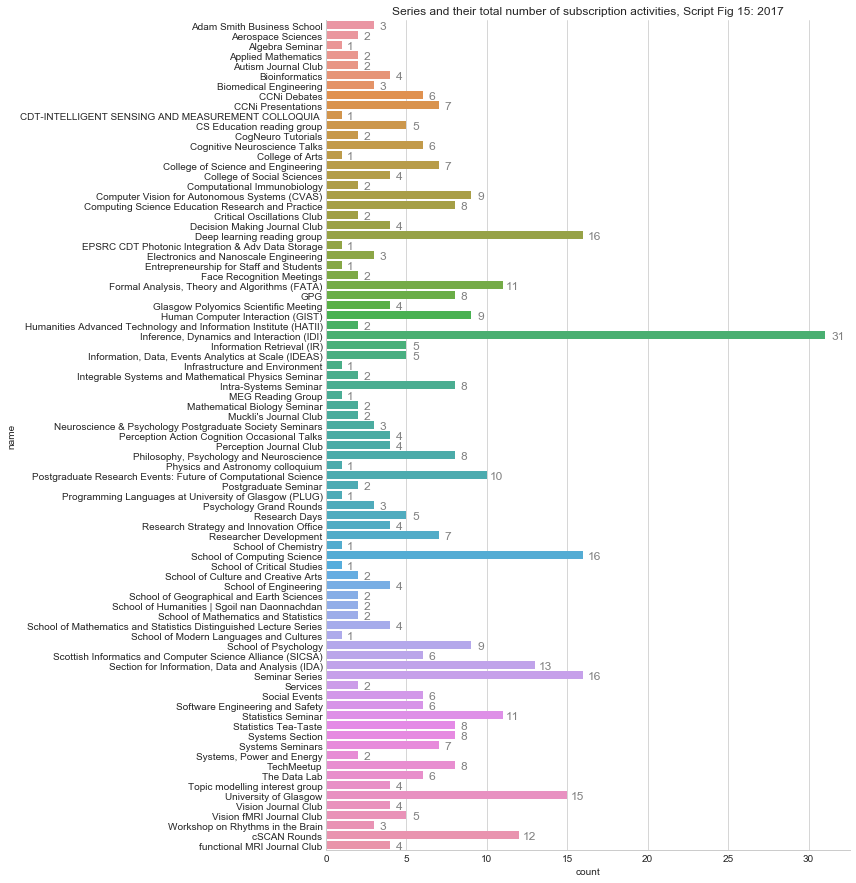

In [59]:
# [4] Now let's plot the series with the total number of subscription activity this academic year

if series_details.empty:
    print('Dataframe is empty')
else:
    #Let sort the chart data in alphabetical order
    data =series_details.sort_values('name',ascending=True)

    g = sns.factorplot( y="name" , 
                       data=data, kind="count",  size=12)


    plt.title("Series and their total number of subscription activities, Script Fig 15: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
         if p.get_height() > 0:
            ax.text( 0.5+p.get_width()+p.get_width()*0.01,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center")

# [4.1]  Series with the total number of subscribe and unsubscribe activity this acedemic year

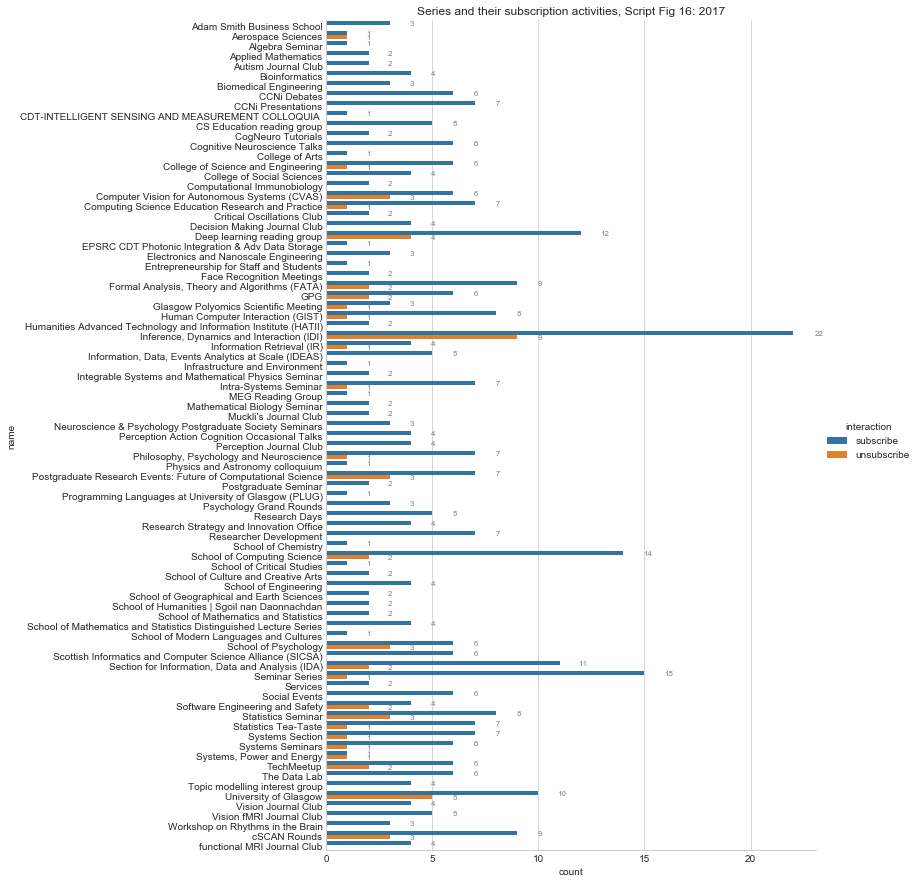

In [60]:
# [4.1]  Now let's plot the series with the total number of subscribe and unsubscribe activity this acedemic year

if series_details.empty:
    print('Dataframe is empty')
else:
    #Let sort the chart data in alphabetical order
    data =series_details.sort_values('name',ascending=True)

    g = sns.factorplot( y="name" , 
                       data=data, kind="count", hue="interaction",  size=12)


    plt.title("Series and their subscription activities, Script Fig 16: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width() > 0:
            ax.text(  1+p.get_width()+p.get_width()*0.01,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=8, color='grey', ha='center', va="center")

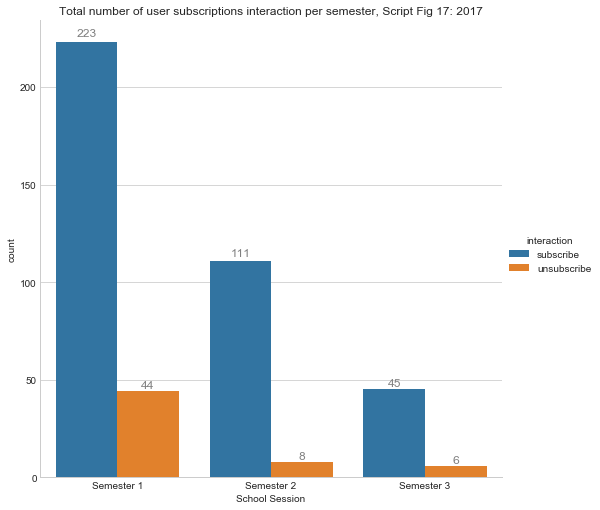

In [61]:
# [4.2] Now let's plot the total number of user subscriptions interaction per semester
if series_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" , 
                       data=series_details, kind="count", hue='interaction', size=7)

    plt.title("Total number of user subscriptions interaction per semester, Script Fig 17: "  +str(year_entered))



    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
         if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [4.3] Subscriptions interaction by user type the whole academic year

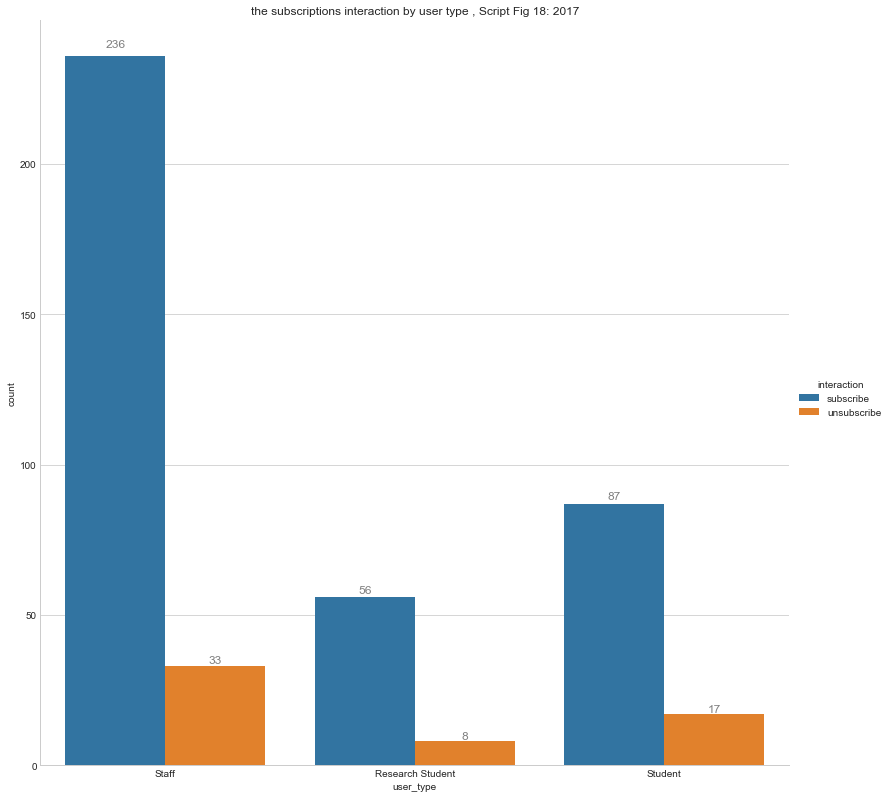

In [62]:
# [4.3] Now let's plot the subscriptions interaction by user type the whole academic year
if series_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="user_type" , 
                       data=series_details, kind="count", hue='interaction', size=11)

    plt.title("the subscriptions interaction by user type , Script Fig 18: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
         if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [4.4] Total number of user subscriptions interaction by usertype per semester

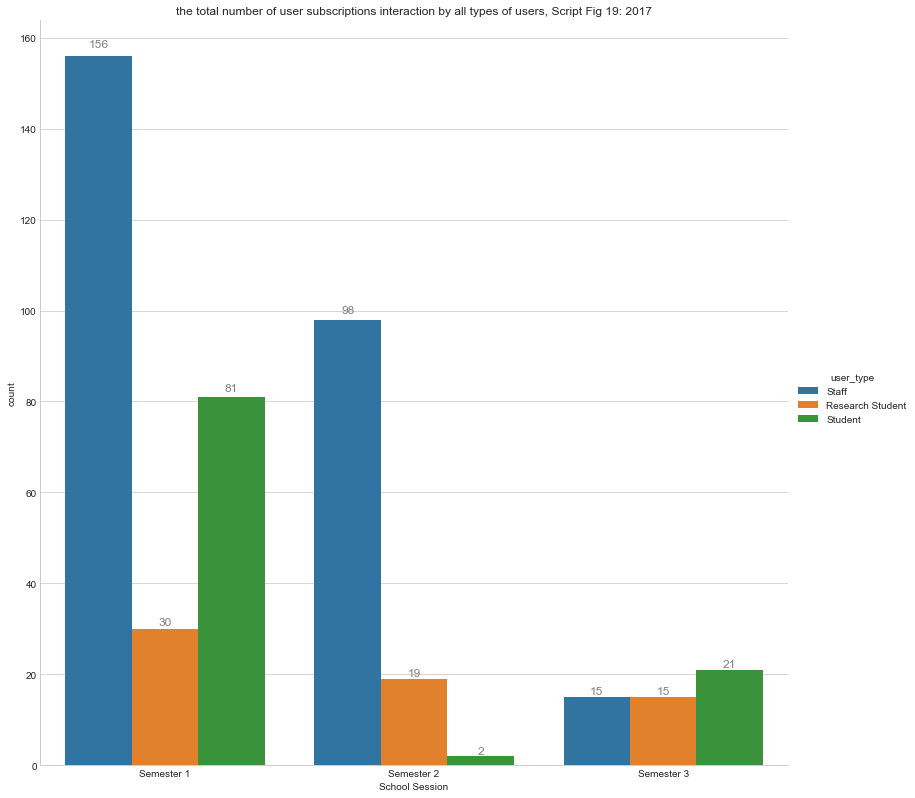

In [63]:
#[4.4] Now let's plot the total number of user subscriptions interaction by usertype per semester
if series_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="School Session" , 
                       data=series_details, kind="count", hue='user_type', size=11)

    plt.title("the total number of user subscriptions interaction by all types of users, Script Fig 19: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
         if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [4.5] Total number of user subscriptions interaction for every hour of the day 

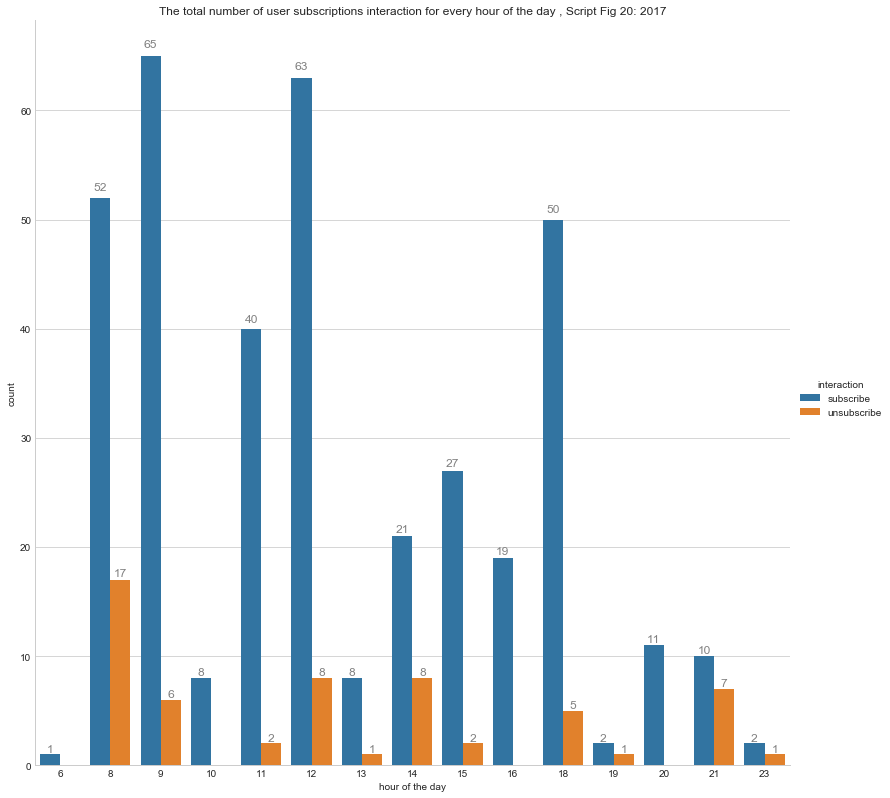

In [64]:
#[4.5] Now let's plot the total number of user subscriptions interaction for every hour of the day the whole academic year
if series_details.empty:
    print('Dataframe is empty')
else:
    g = sns.factorplot( x="hour of the day" , 
                       data=series_details, kind="count", hue='interaction', size=11)

    plt.title("The total number of user subscriptions interaction for every hour of the day , Script Fig 20: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

In [65]:
# Web Editor's Activities - Visualisation for user who edit the system i.e. add, update or delete events. It also gives the time in which these editing occurred.


#We want to load the SQL data for web editors from MYSQL database
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

webedit_details = pd.read_sql("SELECT IFNULL(guid,'Not known') AS guid, timestamp, action FROM webeditor WHERE timestamp >="+"'"
                           +str(year_entered)+".09.01'" + "AND" + " timestamp <="  +  "'" +str(year_entered+1)+ ".09.01'"  + " ORDER BY timestamp;", con=mysql_cn)   

#Now let open the series_details in dataFrame
dframe1 = DataFrame(webedit_details)

dframe1.head()

if webedit_details.empty:
    print('DataFrame is empty!')

In [66]:
#Now let's display the webedit_details table
new_columns = ['guid','timestamp','action']

webedit_details = dframe1.reindex(columns=new_columns)

webedit_details.head()

if webedit_details.empty:
    print('DataFrame is empty!')

In [67]:
#Create a method to indicate whether anonomous user /student or non-student

def thestudents (usertype):

    thequery = usertype.str.split()
    try:
        for words in thequery:
            if words[0][0][0].islower():
                return 'Staff'
            elif words[0][0][0].isnumeric():
                return 'Student'
    except: 
        
        return "Not Known"

In [68]:
#Method to get days value in strings
def __str__(dateandtime):
    theday = str(dateandtime)
    theday = theday.replace("timestamp","")
    theday = theday[0:22]
    return theday

#Add new column - Time_Series
webedit_details['timestamp'] = webedit_details[['timestamp']].apply(__str__,axis=1)

webedit_details.head()

if webedit_details.empty:
    print('DataFrame is empty!')

In [69]:
webedit_details["guid"].head()

0      rwms1u
1      rwms1u
2    0909928m
3      am468d
4      am468d
Name: guid, dtype: object

In [70]:
#Column to show specific day and time of the day

webedit_details['days_value'] = webedit_details[['timestamp']].apply(days_Value,axis=1)

webedit_details['month_value'] = webedit_details[['timestamp']].apply(months_Value,axis=1)

webedit_details['hour of the day'] = webedit_details[['timestamp']].apply(hours_Value,axis=1)

webedit_details['hour label'] = webedit_details[['timestamp']].apply(hourlabel_Value,axis=1)

webedit_details['period'] = webedit_details[['timestamp']].apply(defineDays,axis=1)

webedit_details['School Session'] = webedit_details[['timestamp']].apply(semester,axis=1)

webedit_details['user_type'] = webedit_details[['guid']].apply(thestudents,axis=1)

webedit_details.head()

if webedit_details.empty:
    print('DataFrame is empty!')

# [5] The total number of editors action per semester this academic year 

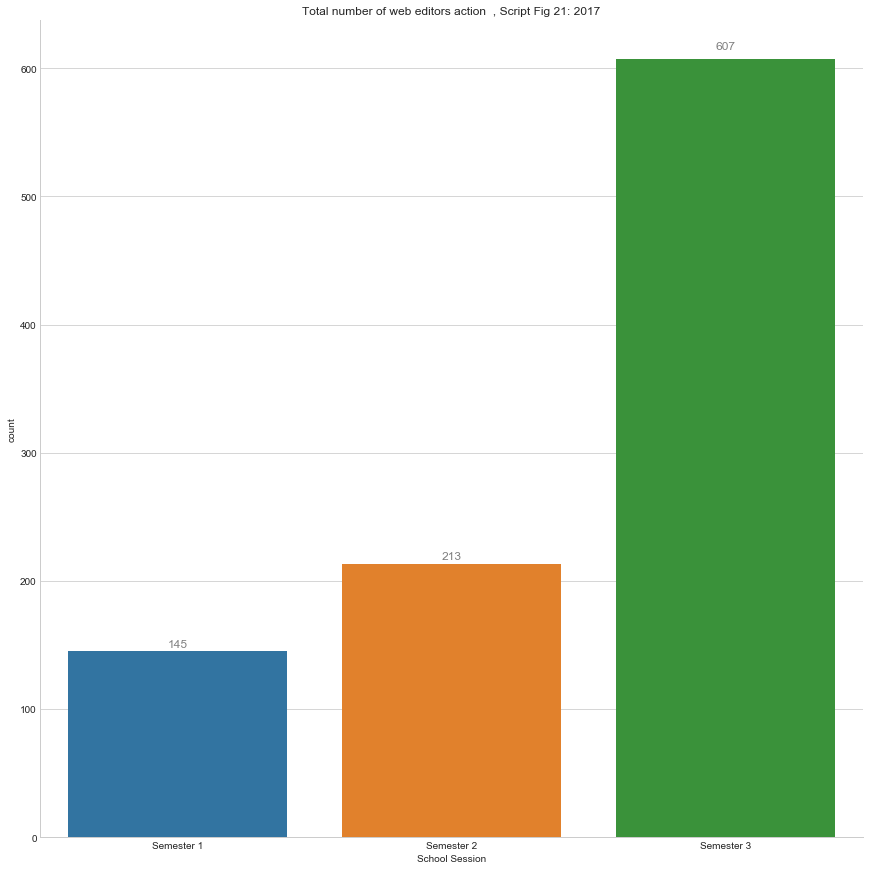

In [71]:
# [5] The total number of editors action per semester this academic year 
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="School Session" , data=webedit_details, kind="count", size=12)
    plt.title("Total number of web editors action  , Script Fig 21: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [5.1] Now let's plot the total number of web editors action for each user type per semester

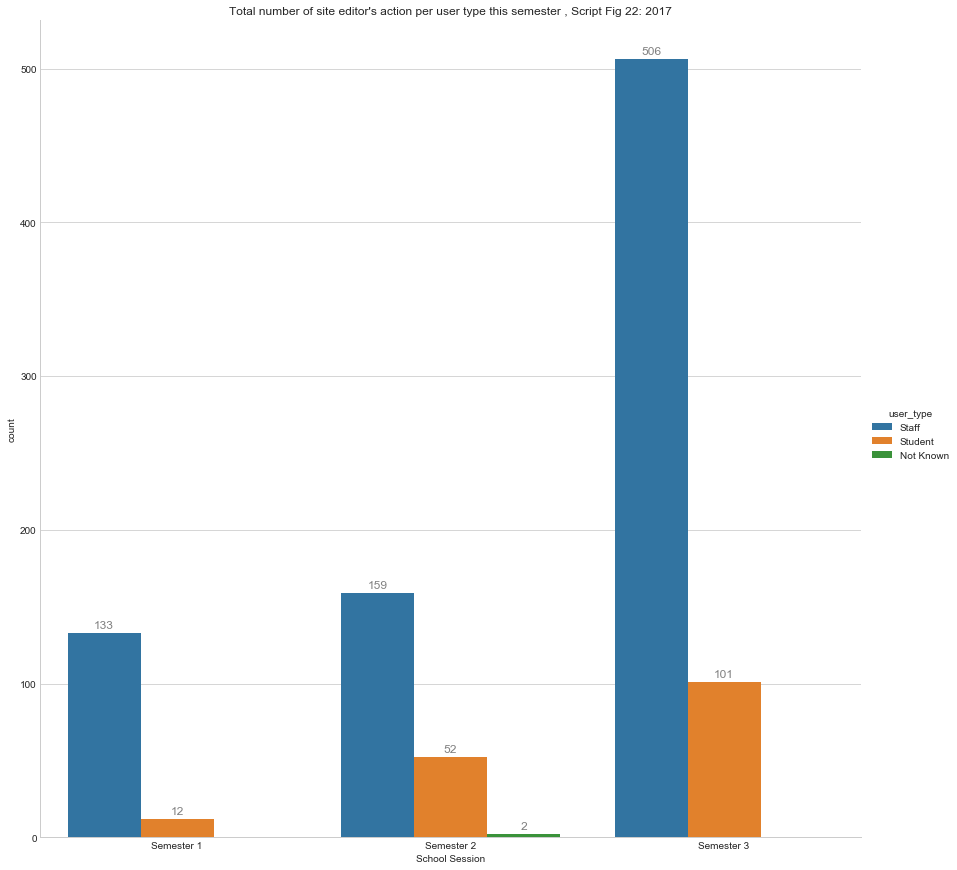

In [72]:
# [5.1] Now let's plot the total number of web editors action for each user type per semester
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="School Session" , data=webedit_details, kind="count", size=12, hue='user_type')
    plt.title("Total number of site editor's action per user type this semester , Script Fig 22: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+2, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [5.2] Total number of the individual web editors action this academic year

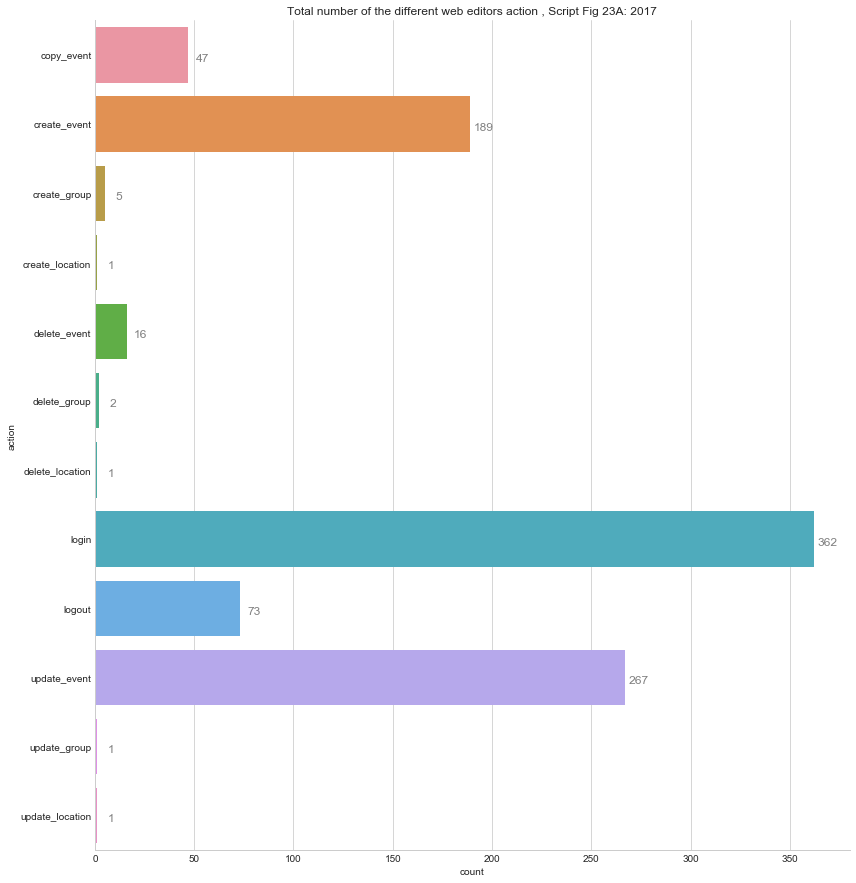

In [73]:
# [5.2] Now let's plot the total number of the individual web editors action this academic year
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    #Let sort the chart data in alphabetical order
    data =webedit_details.sort_values('action',ascending=True)
    g = sns.factorplot( y="action" , data=data, kind="count",size=12)
    plt.title("Total number of the different web editors action , Script Fig 23A: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches: 
        if p.get_height() > 0:
            ax.text( 7+p.get_width(),p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center")

# [5.3] Busiest web editing month of the academic year 

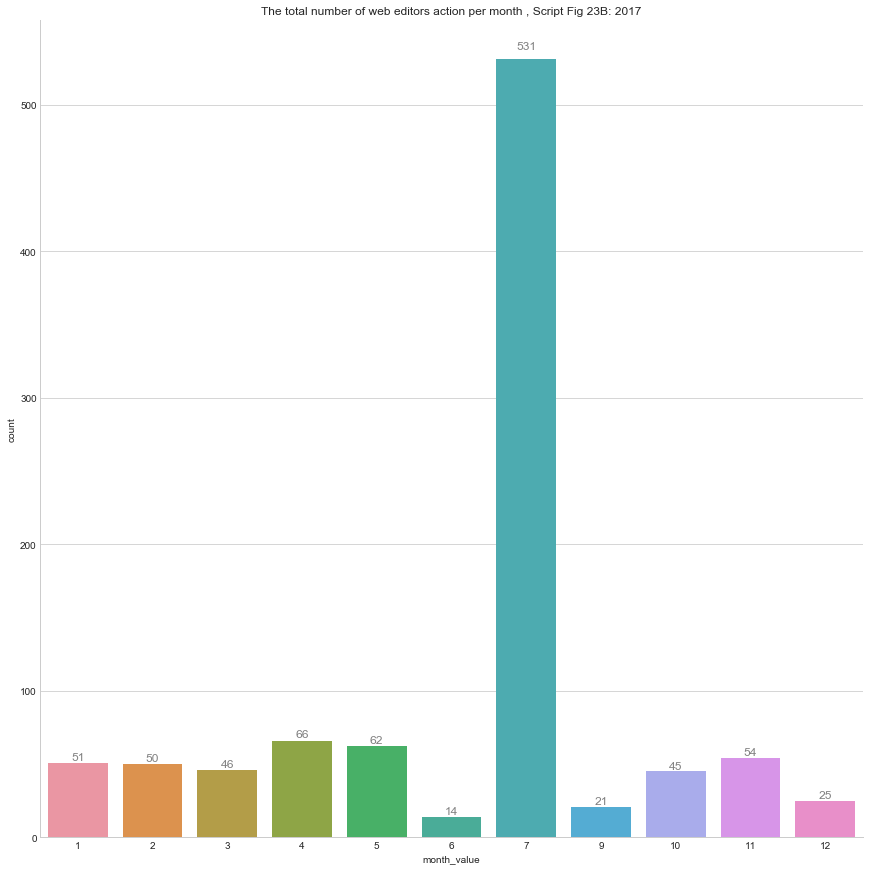

In [74]:
# [5.3] Now let's check the busiest web editing month of the academic year 
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="month_value" , data=webedit_details, kind="count",size=12)
    plt.title("The total number of web editors action per month , Script Fig 23B: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [5.4] The check of the busiest hour of the day for web editors this academic 

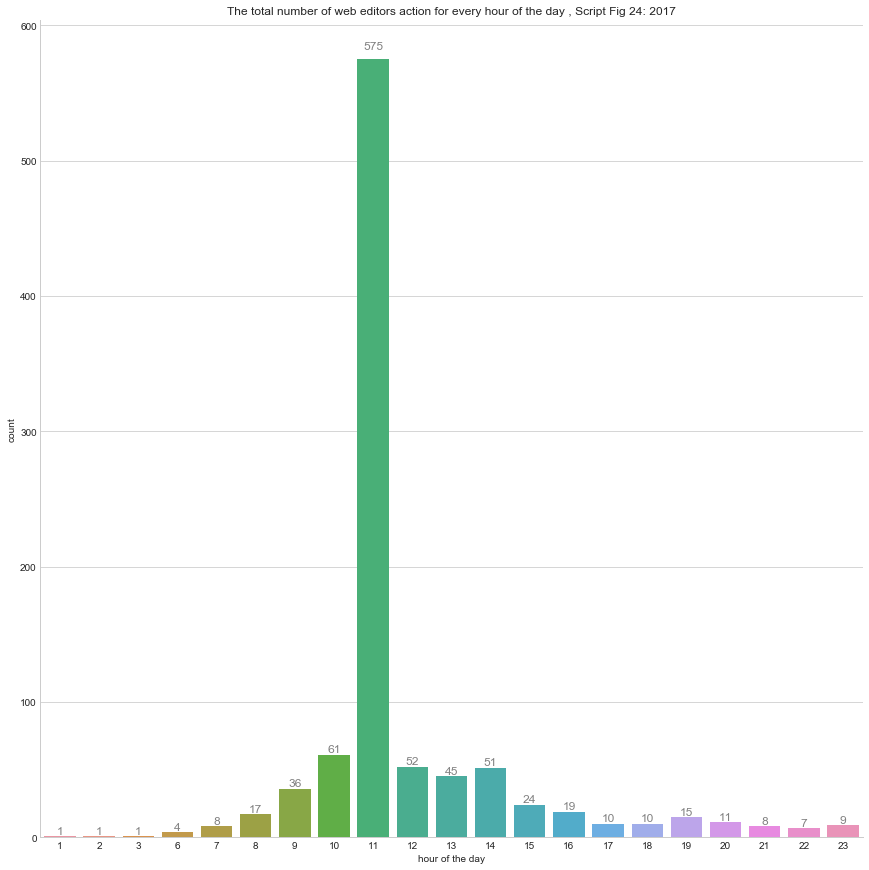

In [75]:
# [5.4] The check of the busiest hour of the day for web editors this academic 
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="hour of the day" ,  data=webedit_details, kind="count", size=12)
    plt.title("The total number of web editors action for every hour of the day , Script Fig 24: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height() > 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')


# [5.5] Now plot of the different web editor action per semester this academic year 

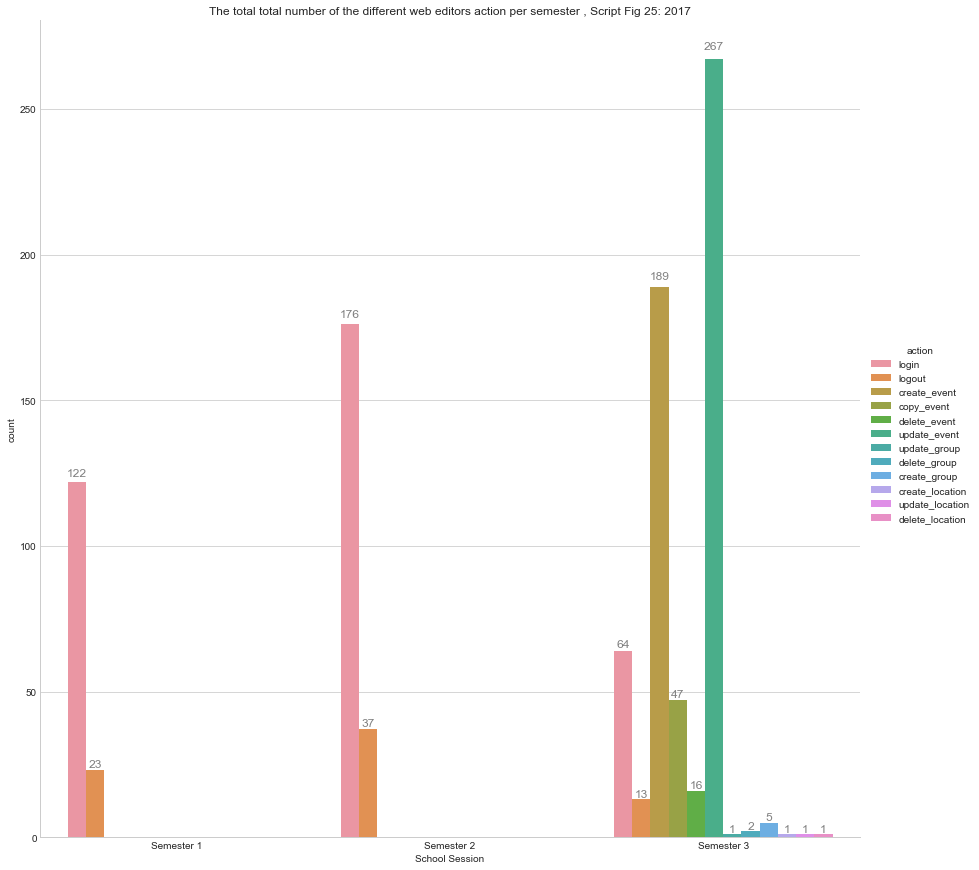

In [76]:
# [5.5] Now plot of the different web editor action per semester this academic  year 
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="School Session" , data=webedit_details, kind="count", hue='action', size=12)
    plt.title("The total total number of the different web editors action per semester , Script Fig 25: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')


# [5.6] The different web editors action this academic year by user_type 

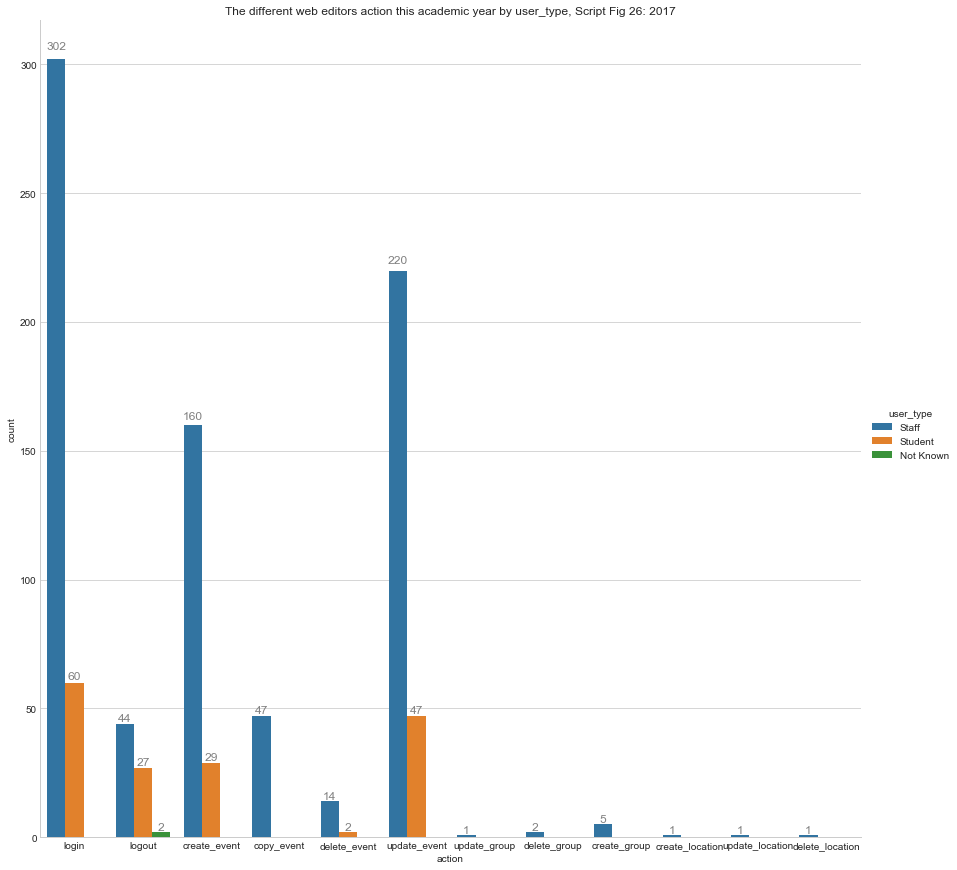

In [77]:
# [5.6] For each web editor’s activity this academic year, a check on whether it is was performed by staff or student 
if webedit_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="action" , data=webedit_details, kind="count", hue="user_type", size=12)
    plt.title("The different web editors action this academic year by user_type, Script Fig 26: "  +str(year_entered))
    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

In [78]:
# Users - Visualisation of which user subscribed to receiving email and/or have an active calendar.

#We want to load the SQL data for users from MYSQL database

mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talksdb_copy')

calendar_details = pd.read_sql("SELECT email,currentLogin, IFNULL(icalId,'Calender not active') AS icalId, markedReminders FROM talksdb_copy.users WHERE currentLogin >="+"'"
                           +str(year_entered)+".09.01'" + "AND" + " currentLogin <="  +  "'" +str(year_entered+1)+ ".09.01';", con=mysql_cn)   

#Now let open the series_details in dataFrame
calendar_details = DataFrame(calendar_details)

calendar_details.head()


,email,currentLogin,icalId,markedReminders
0,Roderick.Murray-Smith@glasgow.ac.uk,2018-06-20 10:20:26,9f45d7b93c98f116997cc943fe26d33b7d0fa2188338b5...,1
1,Andrew.Ramsay@glasgow.ac.uk,2018-06-27 13:30:36,42c11917848a2b7e9fa6a60df76614822b9355c5e68078...,1
2,Simon.Rogers@glasgow.ac.uk,2018-02-12 09:09:10,359b119f7ebf26eb2de33d8ba4f5728f9336d8e35822dd...,1
3,Quintin.Cutts@glasgow.ac.uk,2018-03-18 20:11:52,1ff32f4e42aa57a202ca70c80b34660264af60b655a7f0...,1
4,Bjorn.Jensen@glasgow.ac.uk,2018-06-18 17:46:54,e614bb8fcdca2982b4ee8fa317ef60a1e8769525aa249b...,1


In [79]:
#Let add extra columns to define some table contents

#Create a method to indicate whether user is student or non-student

def students (usertype):

    person = usertype.str.split('@')
    person = person[0][1][0:]
    
    for words in  person:
        if words in 'student':
            return 'Student'
        elif words in 'research':
            return 'Research Student'
        else:
             return 'Staff'

#Let write a function to check if user receives email or not
def emails (usertype):

        if usertype[0] == 0:
            return 'Not receiving emails'
        elif usertype[0] == 1:
            return 'Receiving emails'

#Let write a function to classify calendar or not calendar
def thecalendar (usertype):

        if usertype[0] == "Calender not active":
            return 'Has no calendar'
        else:
            return 'Has Calendar'

In [80]:
#GOD IS EXCELLENT 

calendar_details['user_type'] = calendar_details[['email']].apply(students,axis=1)

calendar_details['email_status'] = calendar_details[['markedReminders']].apply(emails,axis=1)

calendar_details['calendar_status'] = calendar_details[['icalId']].apply(thecalendar,axis=1)


calendar_details.head()

,email,currentLogin,icalId,markedReminders,user_type,email_status,calendar_status
0,Roderick.Murray-Smith@glasgow.ac.uk,2018-06-20 10:20:26,9f45d7b93c98f116997cc943fe26d33b7d0fa2188338b5...,1,Staff,Receiving emails,Has Calendar
1,Andrew.Ramsay@glasgow.ac.uk,2018-06-27 13:30:36,42c11917848a2b7e9fa6a60df76614822b9355c5e68078...,1,Staff,Receiving emails,Has Calendar
2,Simon.Rogers@glasgow.ac.uk,2018-02-12 09:09:10,359b119f7ebf26eb2de33d8ba4f5728f9336d8e35822dd...,1,Staff,Receiving emails,Has Calendar
3,Quintin.Cutts@glasgow.ac.uk,2018-03-18 20:11:52,1ff32f4e42aa57a202ca70c80b34660264af60b655a7f0...,1,Staff,Receiving emails,Has Calendar
4,Bjorn.Jensen@glasgow.ac.uk,2018-06-18 17:46:54,e614bb8fcdca2982b4ee8fa317ef60a1e8769525aa249b...,1,Staff,Receiving emails,Has Calendar


# [6] Comparison of the number of staff or student who has their calendar added to the application this academic year

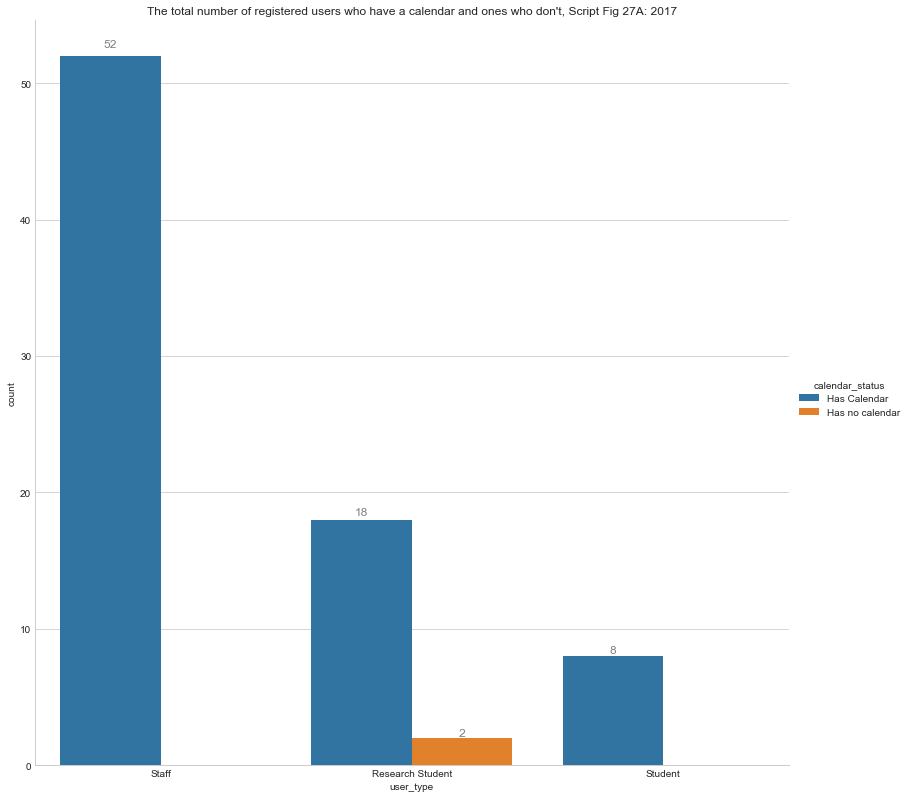

In [81]:
# [6] A comparison of the number of staff or student who has their calendar added to the application
if calendar_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="user_type" , data=calendar_details, kind="count", size=11, hue="calendar_status")
    # Get current axis on current figure
    ax = plt.gca()
    plt.title("The total number of registered users who have a calendar and ones who don't, Script Fig 27A: "  +str(year_entered))
    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

In [82]:
#[6.1] Now let's see how many students actively use their calendars

calendar_check.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
0,66.249.89.221,444182,,None,2017-09-01 00:05:11,None,Feed Query,/events/rest/Feed/user/b2dbd8077c98ed9c066601d...,Not Known,User Feed
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed
453621,130.209.220.100,910873,,None,2018-03-26 12:49:09,None,Feed Query,/events/rest/Feed/user/b025b893324cba299dfbd73...,Not Known,User Feed
453622,130.209.247.252,910874,,None,2018-03-26 12:49:45,None,Feed Query,/events/rest/Feed/user/bc1f55aad98bfbe0822fc9c...,Not Known,User Feed
453623,172.30.170.235,910875,,None,2018-03-26 12:52:11,None,Feed Query,/events/rest/Feed/user/359b119f7ebf26eb2de33d8...,Not Known,User Feed


In [83]:
#List the users

theUsers = calendar_details

theUsers.head()

,email,currentLogin,icalId,markedReminders,user_type,email_status,calendar_status
0,Roderick.Murray-Smith@glasgow.ac.uk,2018-06-20 10:20:26,9f45d7b93c98f116997cc943fe26d33b7d0fa2188338b5...,1,Staff,Receiving emails,Has Calendar
1,Andrew.Ramsay@glasgow.ac.uk,2018-06-27 13:30:36,42c11917848a2b7e9fa6a60df76614822b9355c5e68078...,1,Staff,Receiving emails,Has Calendar
2,Simon.Rogers@glasgow.ac.uk,2018-02-12 09:09:10,359b119f7ebf26eb2de33d8ba4f5728f9336d8e35822dd...,1,Staff,Receiving emails,Has Calendar
3,Quintin.Cutts@glasgow.ac.uk,2018-03-18 20:11:52,1ff32f4e42aa57a202ca70c80b34660264af60b655a7f0...,1,Staff,Receiving emails,Has Calendar
4,Bjorn.Jensen@glasgow.ac.uk,2018-06-18 17:46:54,e614bb8fcdca2982b4ee8fa317ef60a1e8769525aa249b...,1,Staff,Receiving emails,Has Calendar


In [84]:
#Now let's compare the hashcode in the user access table to the hashcodes in the user table

#Let's write a method that will parse the hash in the Access table and add it to a different column
def hash (input):
    try:
        check= input.str.split('er/')
        check= check[0][1][0:]
        return check
    except:
        return 'No valid data'

#Hash
calendar_check['hash'] = calendar_check[['query']].apply(hash,axis=1)

calendar_check.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,hash
0,66.249.89.221,444182,,None,2017-09-01 00:05:11,None,Feed Query,/events/rest/Feed/user/b2dbd8077c98ed9c066601d...,Not Known,User Feed,b2dbd8077c98ed9c066601d9f98cb23a8f24abaa60aabe...
453620,192.41.131.251,910872,,None,2018-03-26 12:47:46,https://samoa.dcs.gla.ac.uk/events/css/bootstr...,Others,/events/fonts/glyphicons-halflings-regular.woff2,Not Known,Not User Feed,No valid data
453621,130.209.220.100,910873,,None,2018-03-26 12:49:09,None,Feed Query,/events/rest/Feed/user/b025b893324cba299dfbd73...,Not Known,User Feed,b025b893324cba299dfbd73414a78c313ae23900abef61...
453622,130.209.247.252,910874,,None,2018-03-26 12:49:45,None,Feed Query,/events/rest/Feed/user/bc1f55aad98bfbe0822fc9c...,Not Known,User Feed,bc1f55aad98bfbe0822fc9c7d33dcfea92edc746bffcf5...
453623,172.30.170.235,910875,,None,2018-03-26 12:52:11,None,Feed Query,/events/rest/Feed/user/359b119f7ebf26eb2de33d8...,Not Known,User Feed,359b119f7ebf26eb2de33d8ba4f5728f9336d8e35822dd...


In [85]:
#User table

#acc= calendar_details['icalId'].str[0:]

#Methods to check the user who have activiely used their calendar
def cal (searchHash):
    for a in searchHash[0:]:
        for b in calendar_details['icalId'][0:]:
            try:
                if a == b:
                    return 'Actively used calendar'
            except:
                        return('No valid data...')

#Methods to add "not active details"
def notActive (active):
    for a in active[0:]:
        try:
            if a =="Actively used calendar":
                return 'Actively used calendar'
            else:
                return "Not actively used calendar"
        except:
                return('User not active on calendar')

In [86]:
#User on calendar

theUsers['Used Cal or not'] = calendar_check[['hash']].apply(cal,axis=1)
theUsers['Used Cal or not'] = theUsers[['Used Cal or not']].apply(notActive,axis=1)

theUsers.head()

,email,currentLogin,icalId,markedReminders,user_type,email_status,calendar_status,Used Cal or not
0,Roderick.Murray-Smith@glasgow.ac.uk,2018-06-20 10:20:26,9f45d7b93c98f116997cc943fe26d33b7d0fa2188338b5...,1,Staff,Receiving emails,Has Calendar,Not actively used calendar
1,Andrew.Ramsay@glasgow.ac.uk,2018-06-27 13:30:36,42c11917848a2b7e9fa6a60df76614822b9355c5e68078...,1,Staff,Receiving emails,Has Calendar,Not actively used calendar
2,Simon.Rogers@glasgow.ac.uk,2018-02-12 09:09:10,359b119f7ebf26eb2de33d8ba4f5728f9336d8e35822dd...,1,Staff,Receiving emails,Has Calendar,Not actively used calendar
3,Quintin.Cutts@glasgow.ac.uk,2018-03-18 20:11:52,1ff32f4e42aa57a202ca70c80b34660264af60b655a7f0...,1,Staff,Receiving emails,Has Calendar,Not actively used calendar
4,Bjorn.Jensen@glasgow.ac.uk,2018-06-18 17:46:54,e614bb8fcdca2982b4ee8fa317ef60a1e8769525aa249b...,1,Staff,Receiving emails,Has Calendar,Not actively used calendar


# [6.1] Plot for user who have actively used their calendar this academic year

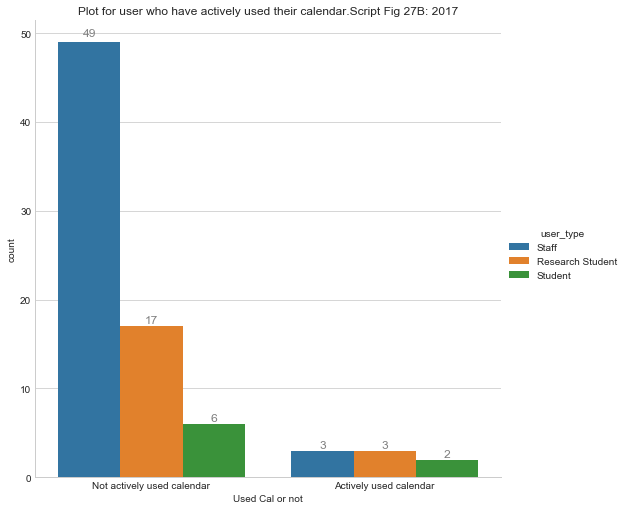

In [87]:
# [6.1] Plot for user who have actively used their calendar
if theUsers.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="Used Cal or not" , 
                       data=theUsers, kind="count", size=7,hue='user_type')

    plt.title("Plot for user who have actively used their calendar.Script Fig 27B: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
               fontsize=12, color='grey', ha='center', va='bottom')

# [6.1b] The total number of registered user who receive emails and the one who don’t 

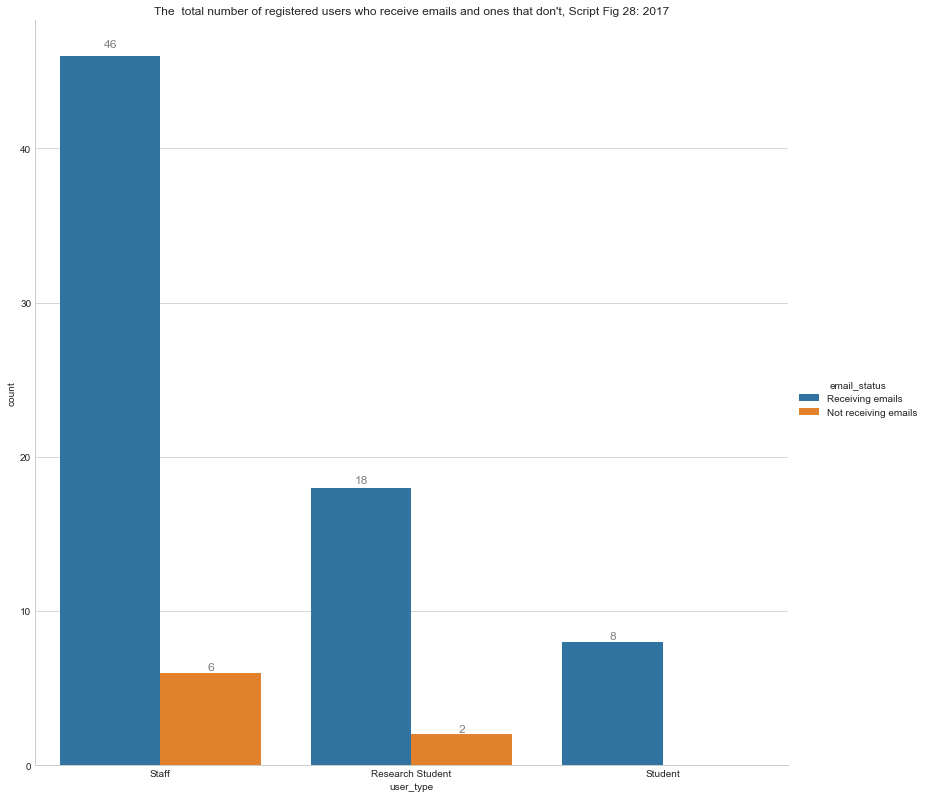

In [88]:
# [6.1b] The total number of registered user who receive emails and the one who don’t 
if theUsers.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="user_type" , 
                       data=calendar_details, kind="count", size=11, hue="email_status")

    plt.title("The  total number of registered users who receive emails and ones that don't, Script Fig 28: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

In [89]:
#[7] Student White List - Visualisation of students who have access to some staff priviledges.

#We want to load the SQL data for  white list from MYSQL database

mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talksdb_copy')

students_details = pd.read_sql("SELECT * FROM talksdb_copy.studentwhitelist;", con=mysql_cn)   

#Now let open the calendar_details in dataFrame
students_details = DataFrame(students_details)

students_details


,id,guid
0,1,0002756r
1,2,0909928m
2,3,2050368x
3,4,0502504m
4,5,2058656a
5,11,1002105a
6,12,2108538s
7,14,2338839r


In [90]:
#Create a method to indicate whether anonomous user /student or non-student

def thestudents (usertype):

    thequery = usertype.str.split()
    try:
        for words in thequery:
            if words[0][0][0].islower():
                return 'Staff'
            elif words[0][0][0].isnumeric():
                return 'Student'
    except: 
        
        return "Not Known"

In [91]:
#Let's add a new student column
students_details['student_status'] = students_details[['guid']].apply(thestudents,axis=1)

students_details.head()

,id,guid,student_status
0,1,0002756r,Student
1,2,0909928m,Student
2,3,2050368x,Student
3,4,0502504m,Student
4,5,2058656a,Student


# 7) Now let's plot the total number of student in the student white list

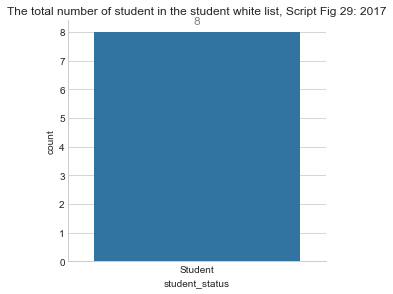

In [92]:
# 7) Now let's plot the total number of student in the student white list

if students_details.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="student_status" , 
                       data=students_details, kind="count", size=4)

    plt.title("The total number of student in the student white list, Script Fig 29: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.2, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

In [93]:
#(8) Location - Visualisation of the location where these talks occur the most. Also whether or not the speakers are internal or external

#0) Talks - Visualising the total number of talks by each organisation group this academic year.

#Import libaries required to perform analysis
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from __future__ import division


mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talksdb_copy')

talk_details  =  pd.read_sql("SELECT T.id, T.title, T.starttime, T.endtime, T.speaker, T.speakerAffiliation,T.speakerurl, T.lastModified, T.lastModifiedGuid,   L.location, ou.name, ou.id, ou.parentOU FROM organisationalUnits AS ou INNER JOIN  talks  AS T ON T.owningOU = ou.id  INNER JOIN locations AS L ON T.location = L.id where T.starttime >="+"'"
                           +str(year_entered)+".09.01'"+ "AND" + " starttime <="  +  "'" +str(year_entered+1)+ ".09.01';", con=mysql_cn)   
  

#Now let open the calendar_details in dataFrame
talk_location = DataFrame(talk_details)

dframe = DataFrame(talk_location)
dframe.to_csv('talklocations.csv')
dframe =pd.read_csv('talklocations.csv')
data = dframe.sort_values('location',ascending=True)


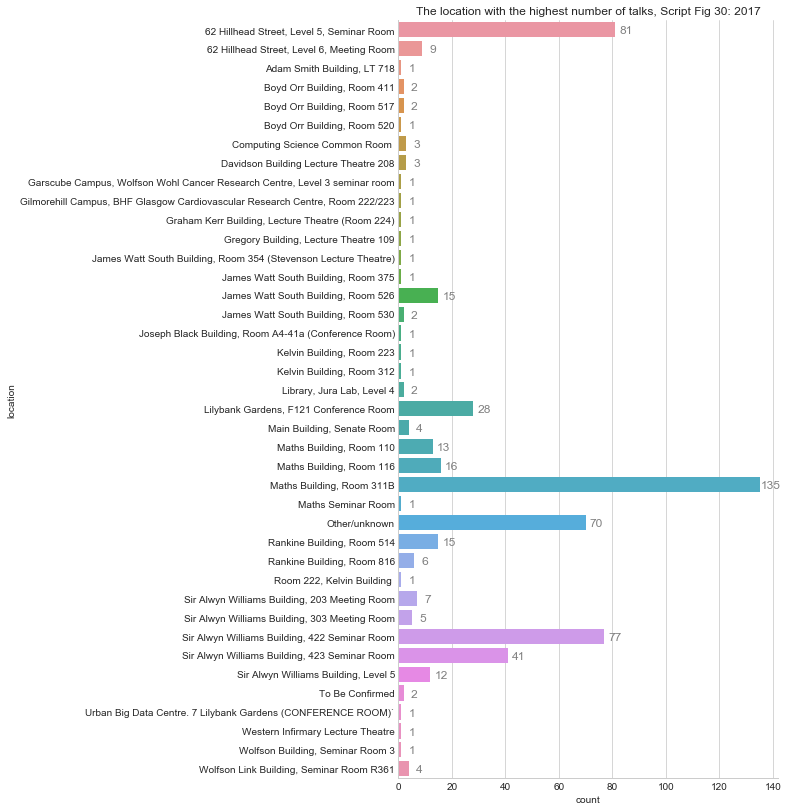

In [94]:
# [8] The location that has hosted the highest number of talks this academic year 
if data.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( y="location" , data=data, kind="count", size=11, orient="v")

    plt.title("The location with the highest number of talks, Script Fig 30: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text( 4+p.get_width(),p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center")

# [8] The location that has hosted the highest number of talks this academic year 

In [95]:
#Now let's write a method to indicated if the speaker is internal or external

def internal_external (speaker):
    #Take the speaker Affiliation details
    thewords = speaker.str.split()
    thewords = thewords
    #for words in thewords:
    try:
        if 'Glasgow' in thewords[0][0:] or 'UoG' in thewords[0][0:] or 'Science' in thewords[0][-1] or 'Statistics' in thewords[0][-1]  :
            return 'internal'
        else:
            return 'external'
    except:
        return 'No Affifliation Indicated'
        

In [96]:
#Now lets add the new column called speaker_internal_external to the talk_details table
talk_details['Talk_Speaker'] = talk_details[['speakerAffiliation']].apply(internal_external,axis=1)
dframe = DataFrame(talk_details)
dframe.to_csv('talk-ou-location.csv')
dframe =pd.read_csv('talk-ou-location.csv')
talk_details = dframe

# [9] The total number of external or internal speakers this academic year

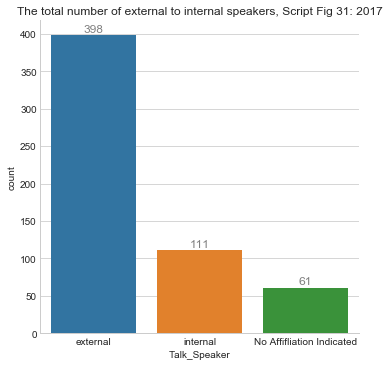

In [97]:
# [9] The total number of external or internal speakers this academic year 
talk_speaker_EI = talk_details
if talk_speaker_EI.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="Talk_Speaker" , 
                       data=talk_speaker_EI, kind="count", size=5,margin_titles=True)

    plt.title("The total number of external to internal speakers, Script Fig 31: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
         if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+2, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [9.1] An internal/external speaker distribution for every organisational group this academic year.

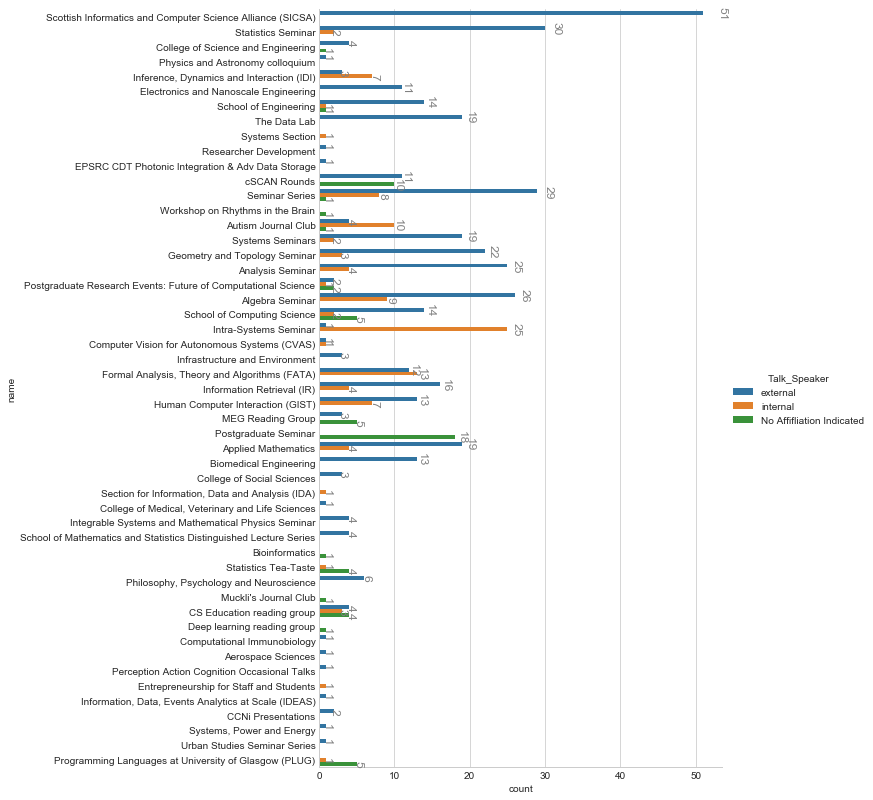

In [98]:
# [9.1] An internal/external speaker distribution for every organisational group this academic year.
talk_speaker_EI = talk_details
if talk_speaker_EI.empty:
    print('DataFrame is empty!')
else:
    #Let sort the chart data in alphabetical order
    data =talk_speaker_EI.sort_values('name',ascending=True)

    g = sns.factorplot( y="name" , 
                       data=talk_details, kind="count",hue ="Talk_Speaker", size=11)

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width()> 0:
            ax.text( p.get_width()+p.get_width()*0.05,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='grey', ha='center', va="center", rotation="-90")

In [99]:
#Now it is time to plot time series information
#We are going to get the number of days between now and when the talk was uploaded
import datetime
from datetime import datetime, timedelta

#Method to get number of days and days description string
def getNumberOfDays (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    if days < 0:
        return 'future talks'
    elif days == 0:
        return "within 24 hours" 
    elif days > 0 and days < 7:
        return '1 to 7 days ago'
    elif days >=7 and days <30:
        return "7 to 30 days ago"
    elif days >=30 and days <=180:
        return "within past 6 months"
    elif days >180 and days <100000:
        return 'archived talks'

#method to return actual date values
def days_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    return days
    
    

In [100]:
#Now lets display the talk_details table
new_columns = ['Time_Series','days_Value','title','speaker','speakerAffiliation','name','location','starttime','endtime','lastModified','lastModifiedGuid','parentOU','id','speakerurl']

talk_speaker_EI = talk_speaker_EI.reindex(columns=new_columns)

#Add new column - Time_Series
talk_speaker_EI['Time_Series'] = talk_speaker_EI[['starttime']].apply(getNumberOfDays,axis=1)

#Add new column - days_Value
talk_speaker_EI['days_Value'] = talk_speaker_EI[['starttime']].apply(days_Value,axis=1)

talk_speaker_EI['month_value'] = talk_speaker_EI[['starttime']].apply(months_Value,axis=1)

talk_speaker_EI['hour of the day'] = talk_speaker_EI[['starttime']].apply(hours_Value,axis=1)

talk_speaker_EI['hour label'] = talk_speaker_EI[['starttime']].apply(hourlabel_Value,axis=1)

talk_speaker_EI['School Session'] = talk_speaker_EI[['starttime']].apply(semester,axis=1)

#View the first 5 rows
#talk_speaker_EI.head()
#Display total number of talks in each time series
talk_speaker_EI.sort_values(['starttime'], ascending=[True]).head()

,Time_Series,days_Value,title,speaker,speakerAffiliation,name,location,starttime,endtime,lastModified,lastModifiedGuid,parentOU,id,speakerurl,month_value,hour of the day,hour label,School Session
28,archived talks,363,"Reliable, Secure and Scalable Software Systems...",SICSA Event,SICSA,Scottish Informatics and Computer Science Alli...,Other/unknown,2017-09-01 00:00:00,2017-09-02 00:00:00,2017-05-11 09:46:17,adr7m,3,2994,http://www.sicsa.ac.uk/events/reliable-secure-...,9,0,0-5am,Semester 1
27,archived talks,362,"Reliable, Secure and Scalable Software Systems...","Inah Omoronyia, Phil Trinder, and many others","ARM, Codeplay, EPCC, Maidsafe, Twitter, and Un...",Systems Section,"Sir Alwyn Williams Building, Level 5",2017-09-01 07:45:00,NaN,2017-08-24 07:50:28,pt85b,3,2993,http://www.dcs.gla.ac.uk/research/gpg/RS4/,9,7,6-10am,Semester 1
37,archived talks,362,CAS Scotland Conference 2017,SICSA Event,SICSA,Scottish Informatics and Computer Science Alli...,Other/unknown,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-01 14:35:51,adr7m,3,3008,http://www.sicsa.ac.uk/events/cas-scotland-con...,9,0,0-5am,Semester 1
19,archived talks,358,SICSA Education Workshop on Entrepreneurship.,SICSA Event,SICSA,Scottish Informatics and Computer Science Alli...,Other/unknown,2017-09-05 09:00:00,2017-09-05 15:30:00,2017-08-16 09:36:10,adr7m,3,2983,http://www.sicsa.ac.uk/events/sicsa-education-...,9,9,6-10am,Semester 1
29,archived talks,356,"Silicon Valley Data Science ""Opportunities for...",Data Lab Event,The Data Lab,The Data Lab,Other/unknown,2017-09-07 08:30:00,2017-09-07 11:30:00,2017-08-28 12:15:05,adr7m,74,2995,http://www.thedatalab.comhttp://www.thedatalab...,9,8,6-10am,Semester 1


# [9.2] Display total number of talks in each month this academic year & The total number of talks for the working hours of the day this academic year

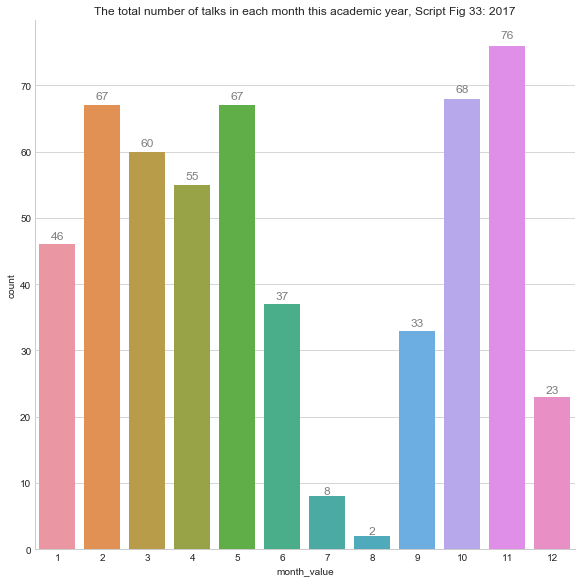

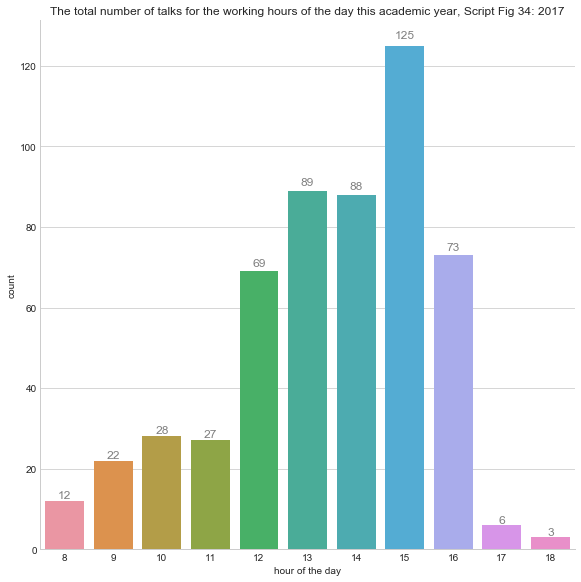

In [101]:
# [9.2] Display total number of talks in each month this academic year
talk_speaker_EI.sort_values(['starttime'], ascending=[False])

if talk_speaker_EI.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="month_value" , 
                      data=talk_speaker_EI[(talk_speaker_EI['hour of the day'] > 7) & (talk_speaker_EI['hour of the day'] <=18)], kind="count", size=8,margin_titles=True)

    plt.title("The total number of talks in each month this academic year, Script Fig 33: "  +str(year_entered))

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
                    ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

# [9.3] The most popular starting times for all talks this academic year 
if talk_speaker_EI.empty:
    print('DataFrame is empty!')
else:            
    g = sns.factorplot( x="hour of the day" , 
                       data=talk_speaker_EI[(talk_speaker_EI['hour of the day'] > 7) & (talk_speaker_EI['hour of the day'] <=18)], kind="count", size=8,margin_titles=True)

    plt.title("The total number of talks for the working hours of the day this academic year, Script Fig 34: "  +str(year_entered))



    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
            if p.get_height()> 0:
                    ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')
    


Data for specific pages view are not provided. The page view table provided in the talk_logging database has no rows (empty).
This would have provided information on how many times a specific talk page was viewed, including the time of viewing and the identity of the viewer

Noting from the visualisation above, the system is actively used/visited.
However, important information about the user activities have not fully been recorded. Username column on the Access table and the Page View table information needs to be addressed.

In [102]:
#Now let's analysis the number times a particular talk was viewed

from __future__ import division

mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

#We want to load the SQL data for talk, organisational group and location

talkview_details  =  pd.read_sql("SELECT referer, COUNT(referer) as total FROM access WHERE referer LIKE '%/events/viewtalk.jsp?%' AND timestamp >="+"'"
                           +str(year_entered)+".09.01'"+  "AND" + " timestamp <="  +  "'" +str(year_entered+1)+ ".09.01'"+"GROUP BY referer ORDER BY total;", con=mysql_cn)   


#Now let open the talk_details in s dataFrame

talkview_details = DataFrame(talkview_details)

talkview_details.head()


,referer,total
0,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1
1,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1
2,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1
3,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1
4,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1


In [103]:
from __future__ import division
mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talkslogging_copy')

#We want to load the SQL data for talk, organisational group and location

seriestalk_details =  pd.read_sql("SELECT referer, COUNT(referer) as total FROM access WHERE referer LIKE '%/events/series.jsp?%' AND timestamp >="+"'"
                           +str(year_entered)+".09.01'" +  "AND" + " timestamp <="  +  "'" +str(year_entered+1)+ ".09.01'"+"GROUP BY referer ORDER BY total;", con=mysql_cn)   

#Now let open the seriestalk_details in s dataFrame

seriestalk_details  = DataFrame(seriestalk_details )

seriestalk_details .head()

,referer,total
0,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1
1,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1
2,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1
3,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1
4,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1


In [104]:
#Write a method to get the talk id from the url string

def getId1 (url):
    
    url = url.str.split('=')
    url = url[0][1][0:]
    
    if '0]' in url:
        url = url[:-4]
    elif 'A=' in url:
        url = url[:-4]
    elif '%' in url:
        return '0'
    elif "0]'A" in url:
        url = url[:-6]
    return url
   
def getId(url):
    url = getId1 (url)
    if "'A" in url:
        url = url[:-2]
    if "_______________________________________________" in url:
        url = url[:-47]
    return url

def getIdSeries (url):
    
    url = url.str.split('=')
    url = url[0][1][0:]
    
    if "'A" in url:
        url = url[:-2]
    elif 'A=' in url:
        url = url[:-1]
    elif "7," in url:
        url = url[:-1]
    elif '&' in url:
        url = url[:-3]   
    elif '%' in url:
        return '0'
    return url


In [105]:
#Let's get the talks with the corresponding organisational unit

mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talksdb_copy')

#We want to load the SQL data for talk, organisational group and location

talkviewtitle_details  =  pd.read_sql("SELECT TA.id, TA.title, TA.starttime,TA.speakerAffiliation, TA.owningOu FROM talks as TA INNER JOIN organisationalUnits AS OU ON TA.owningOU=OU.id WHERE TA.starttime >="+"'"
                           +str(year_entered)+".09.01'" +  "AND" + " starttime <="  +  "'" +str(year_entered+1)+ ".09.01';", con=mysql_cn)   


#Now let open the talk_details in s dataFrame

talkviewtitle_details = DataFrame(talkviewtitle_details)

talkviewtitle_details['talkIDRef'] = talkviewtitle_details['id']

talkviewtitle_details.set_index('id', inplace=True)

talkviewtitle_details.head()


,title,starttime,speakerAffiliation,owningOu,talkIDRef
id,,,,,
2645,The SCOttish Networking Event (SCONE),2018-02-20 12:00:00,SICSA,53,2645
2705,"Categories, Logic, and Physics, Scotland",2017-11-20 10:00:00,SICSA,53,2705
2738,SICSA DemoFest 2017,2017-10-03 15:00:00,SICSA,53,2738
2743,19th ACM International Conference on Multimoda...,2017-11-13 00:00:00,SICSA,53,2743
2781,SICSA DemoFest: Bringing Research to Life,2017-10-03 15:00:00,SICSA,53,2781


In [106]:
#Let's get the torganisational unit/series title

mysql_cn= MySQLdb.connect(host='127.0.0.1', port=33060,
                user='readonlytalks', passwd='KAXV5wwC', 
                db='talksdb_copy')

#We want to load the SQL data for talk, organisational group and location

talkseriestitle_details  =  pd.read_sql("select id, name FROM organisationalUnits;", con=mysql_cn)   

#Now let open the talk_details in s dataFrame

talkseriestitle_details = DataFrame(talkseriestitle_details)

talkseriestitle_details['seriesIDRef'] = talkseriestitle_details['id']

talkseriestitle_details.set_index('id', inplace=True)

talkseriestitle_details.head()

,name,seriesIDRef
id,,
1,University of Glasgow,1
2,College of Science and Engineering,2
3,School of Computing Science,3
4,Computer Vision for Autonomous Systems (CVAS),4
5,Systems Section,5


In [107]:
#let view talkview table
talkview_details['talkID'] = talkview_details[['referer']].apply(getId,axis=1)

talkview_details['talkIDRef'] = talkview_details[['referer']].apply(getId,axis=1)

talkview_details.head()


,referer,total,talkID,talkIDRef
0,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9027,9027
1,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9077,9077
2,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,1414,1414
3,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2612,2612
4,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2708,2708


In [108]:
#GOD IS EXCELLENT

seriestalk_details['seriesID'] = seriestalk_details[['referer']].apply(getIdSeries,axis=1)

seriestalk_details['seriesIDRef'] = seriestalk_details[['referer']].apply(getIdSeries,axis=1)

seriestalk_details.head()

,referer,total,seriesID,seriesIDRef
0,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,42,42
1,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,27,27
2,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,73,73
3,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,8,8
4,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,11,11


In [109]:
#make talkID the index

#talkview_details.set_index('talkID')

talkview_details.set_index('talkID', inplace=True)

talkview_details.head()

,referer,total,talkIDRef
talkID,,,
9027,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9027
9077,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9077
1414,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,1414
2612,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2612
2708,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2708


In [110]:
#make talkID the index

seriestalk_details.set_index('seriesID', inplace=True)

seriestalk_details.head()

,referer,total,seriesIDRef
seriesID,,,
42,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,42
27,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,27
73,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,73
8,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,8
11,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,11


In [111]:
talkviewtitle_details.head()

,title,starttime,speakerAffiliation,owningOu,talkIDRef
id,,,,,
2645,The SCOttish Networking Event (SCONE),2018-02-20 12:00:00,SICSA,53,2645
2705,"Categories, Logic, and Physics, Scotland",2017-11-20 10:00:00,SICSA,53,2705
2738,SICSA DemoFest 2017,2017-10-03 15:00:00,SICSA,53,2738
2743,19th ACM International Conference on Multimoda...,2017-11-13 00:00:00,SICSA,53,2743
2781,SICSA DemoFest: Bringing Research to Life,2017-10-03 15:00:00,SICSA,53,2781


In [112]:
talkseriestitle_details.head()


,name,seriesIDRef
id,,
1,University of Glasgow,1
2,College of Science and Engineering,2
3,School of Computing Science,3
4,Computer Vision for Autonomous Systems (CVAS),4
5,Systems Section,5


In [113]:
#Methods to obtain the talk title, starttime, days_value, owing Organisational group and speaker affiliation
def theTalkDetails(alltalks):
    for a in alltalks[0:]:
        for b in talkviewtitle_details['talkIDRef'][0:]:
            try:
                if int(a) == int(b):
                    if a.isdigit:
                        a = int(a)
                        return(talkviewtitle_details.loc[a]['title'])
            except:
                        return('No valid data...')
def theTalkTime(alltalks):
    for a in alltalks[0:]:
        for b in talkviewtitle_details['talkIDRef'][0:]:
            try:
                if int(a) == int(b):
                    if a.isdigit:
                        a = int(a)
                        return str(talkviewtitle_details.loc[a]['starttime'])
            except:
                        return('No valid data...')
def theTalkSpeaker(alltalks):
    for a in alltalks[0:]:
        for b in talkviewtitle_details['talkIDRef'][0:]:
            try:
                if int(a) == int(b):
                    if a.isdigit:
                        a = int(a)
                        return(talkviewtitle_details.loc[a]['speakerAffiliation'])
            except:
                        return('No valid data...')
                
def internal_external (speaker):
    #Take the speaker Affiliation details
    thewords = speaker.str.split()
    thewords = thewords
    #for words in thewords:
    try:
        if 'Glasgow' in thewords[0][0:]  or 'UoG' in thewords[0][0:] or 'Science' in thewords[0][-1] or 'Statistics' in thewords[0][-1] or 'University of Glasgow,physics ' in thewords[0][0:] :
            return 'internal'
        elif 'data...' in thewords[0][0:]:
            return 'No valid data'
        else:
            return 'external'
    except:
        return 'No Affiliation Indicated'

    #So lets split the day and time to visualise query distribution in days and in time

#method to return actual date values
def days_value(dateandtime):
    try:
        #dateandtime = talk_details['starttime']
        theday = dateandtime.str.split('-')
        year = int(theday[0][0])
        month = int(theday[0][1])
        day = int(theday[0][2][0:2])
        hour = int(theday[0][2][3:5])
        mins = int(theday[0][2][6:8])
        seconds = int(theday[0][2][9:11])

        #insert the dates into the datetime method
        a1 = datetime(year,month,day,hour,mins,seconds)

        a2 = datetime.now() - a1

        days = a2.days

        if days >= 0:
            return int(days)
    except:
        return ('0') 

def talkOUDetails(alltalks):
    for a in alltalks[0:]:
        for b in talkviewtitle_details['talkIDRef'][0:]:
            try:
                if int(a) == int(b):
                    if a.isdigit:
                        a = int(a)
                        return(int(talkviewtitle_details.loc[a]['owningOu']))
            except:
                        return('No valid data...')


In [114]:
#Methods to obtain series details
def SeriesDetails(allseries):
    for a in allseries[0:]:
        for b in talkseriestitle_details['seriesIDRef'][0:]:
            try:
                if int(a) == int(b):
                    if a.isdigit:
                        a = int(a)
                        return(talkseriestitle_details.loc[a]['name'])
            except:
                        return('No valid data...')

In [115]:
talkview_details.head()

,referer,total,talkIDRef
talkID,,,
9027,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9027
9077,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9077
1414,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,1414
2612,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2612
2708,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2708


In [116]:
talkview_details['title'] = talkview_details[['talkIDRef']].apply(theTalkDetails,axis=1)

talkview_details['starttime'] = talkview_details[['talkIDRef']].apply(theTalkTime,axis=1)

talkview_details['speakerAffiliation'] = talkview_details[['talkIDRef']].apply(theTalkSpeaker,axis=1)

talkview_details = talkview_details[(talkview_details['title'].notnull())|(talkview_details['title'].str.contains('0')==False) ]

talkview_details['InternalExternalSpeaker'] = talkview_details[['speakerAffiliation']].apply(internal_external,axis=1)

talkview_details['days_uploaded'] = talkview_details[['starttime']].apply(days_value,axis=1)

talkview_details['owingOU'] = talkview_details[['talkIDRef']].apply(talkOUDetails,axis=1)



talkview_details.head()


,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU
talkID,,,,,,,,,
9027,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9027,Recurrent Neural Networks for Session-based Re...,2018-05-18 13:00:00,"Telefonica Research, Barcelona",external,103,3
8214,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,8214,Language Adapts to Interaction,2017-11-10 13:00:00,"Department of Archaeology and Anthropology,\nU...",external,292,88
8567,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,8567,The ecological and evolutionary consequences o...,2017-11-30 14:00:00,University of Strathclyde,external,272,42
2645,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2645,The SCOttish Networking Event (SCONE),2018-02-20 12:00:00,SICSA,external,190,53
8266,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,8266,WoRB Workshop on Rhythms in the Brain,2017-09-11 08:15:00,,No Affiliation Indicated,352,98


In [117]:
seriestalk_details['title'] =seriestalk_details[['seriesIDRef']].apply(SeriesDetails,axis=1)

seriestalk_details = seriestalk_details[(seriestalk_details['title'].notnull())|(seriestalk_details['title'].str.contains('0')==False) ]

seriestalk_details.head()

,referer,total,seriesIDRef,title
seriesID,,,,
42,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,42,Applied Mathematics
27,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,27,Systems Seminars
73,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,73,School of Mathematics and Statistics Distingui...
8,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,8,"Inference, Dynamics and Interaction (IDI)"
11,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,1,11,"Section for Information, Data and Analysis (IDA)"


In [118]:
#Testing
try:
    for a in seriestalk_details['seriesIDRef'][0:]:
        for b in talkseriestitle_details['seriesIDRef'][0:]:
            try:
                if int(a) == int(b):
                    if a.isdigit:
                        a = int(a)
                        print(talkseriestitle_details.loc[a]['name'])
            except:
                        print('No valid data...')
except:
    print (a)

Applied Mathematics
Systems Seminars
School of Mathematics and Statistics Distinguished Lecture Series
Inference, Dynamics and Interaction (IDI)
Section for Information, Data and Analysis (IDA)
Information Retrieval (IR)
Researcher Development
Computing Science Education Research and Practice
Formal Analysis, Theory and Algorithms (FATA)
Human Computer Interaction (GIST)
Seminar Series
Algebra Seminar
School of Social & Political Sciences
Continuum Mechanics Seminar
School of Modern Languages and Cultures
CS Education reading group
Glasgow Polyomics Scientific Meeting
School of Education
Joseph Black Research Lecture
Computational Immunobiology
School of Chemistry
Perception Action Cognition Occasional Talks
SofTMech
Neuroscience & Psychology Postgraduate Society Seminars
School of Culture and Creative Arts
Workshop on Rhythms in the Brain
Sleep Research Group Meetings
Researcher Development
Critical Oscillations Club
School of Geographical and Earth Sciences
CDT-INTELLIGENT SENSING AN

In [119]:
talkseriestitle_details['seriesIDRef'][0:].head()

id
1    1
2    2
3    3
4    4
5    5
Name: seriesIDRef, dtype: int64

In [120]:
def __str__(dateandtime):
    try:
        #dateandtime = talk_details['starttime']
        theday = dateandtime.str.split('-')
        year = int(theday[0][0])
        month = int(theday[0][1])
        day = int(theday[0][2][0:2])
        hour = int(theday[0][2][3:5])
        mins = int(theday[0][2][6:8])
        seconds = int(theday[0][2][9:11])

        #insert the dates into the datetime method
        a1 = datetime(year,month,day,hour,mins,seconds)

        a2 = datetime.now() - a1

        days = a2.days

        if days >= 0:
            return ' ('+str(days) + ' days ago'+')'
    except:
        return ('0')

#method to change the column to an int
def intTotal (number):
    number=int(number)
    return number

In [121]:
talkview_details['when'] = talkview_details[['starttime']].apply(__str__,axis=1)
talkview_details['days_uploaded'] = talkview_details[['days_uploaded']].apply(intTotal ,axis=1)
talkview_details.head()

,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU,when
talkID,,,,,,,,,,
9027,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,9027,Recurrent Neural Networks for Session-based Re...,2018-05-18 13:00:00,"Telefonica Research, Barcelona",external,103,3,(103 days ago)
8214,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,8214,Language Adapts to Interaction,2017-11-10 13:00:00,"Department of Archaeology and Anthropology,\nU...",external,292,88,(292 days ago)
8567,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,8567,The ecological and evolutionary consequences o...,2017-11-30 14:00:00,University of Strathclyde,external,272,42,(272 days ago)
2645,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,2645,The SCOttish Networking Event (SCONE),2018-02-20 12:00:00,SICSA,external,190,53,(190 days ago)
8266,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,1,8266,WoRB Workshop on Rhythms in the Brain,2017-09-11 08:15:00,,No Affiliation Indicated,352,98,(352 days ago)


In [122]:

talkview_details['title_when'] =talkview_details['title'] +' '+talkview_details['when']

talkview_details['viewPerformancerRatio'] = talkview_details['total'] / talkview_details['days_uploaded']

talkview_details =talkview_details[talkview_details['total']>30]

talkview_details.head()

,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU,when,title_when,viewPerformancerRatio
talkID,,,,,,,,,,,,
8910,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8910,Mining the Polyome: Finding patterns in compl...,2018-05-25 13:00:00,University of Glasgow,internal,96,3,(96 days ago),Mining the Polyome: Finding patterns in compl...,0.333333
9017,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,9017,Understanding Capsule Networks,2018-05-16 12:00:00,"Computer Vision and Autonomous Group, School o...",internal,105,4,(105 days ago),Understanding Capsule Networks (105 days ago),0.304762
8694,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8694,Future Assistive Technologies for Cognition,2018-01-18 13:00:00,University of Glasgow,internal,223,7,(223 days ago),Future Assistive Technologies for Cognition (...,0.143498
8791,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8791,Approaches to analysis of genomic data,2018-01-17 12:00:00,University of Glasgow,internal,224,8,(224 days ago),Approaches to analysis of genomic data (224 d...,0.142857
8867,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,37,8867,Interactive Visualizations for Data Exploratio...,2018-06-07 12:00:00,University of Edinburgh,external,83,7,(83 days ago),Interactive Visualizations for Data Exploratio...,0.445783


# [10]  Talk pages with the highest number of views (Views > 30)

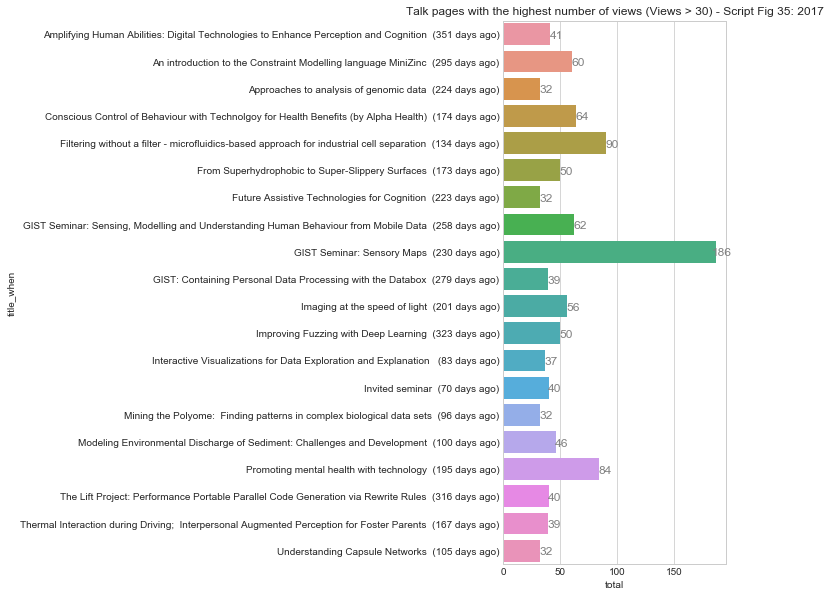

In [123]:
# [10]  Talk pages with the highest number of views (Views > 30)
    
data = talkview_details.sort_values('title_when',ascending=True)

plt.subplots(figsize=(4, 10))

plt.title("Talk pages with the highest number of views (Views > 30) - Script Fig 35: "  +str(year_entered))

g = sns.barplot( y='title_when', x="total"  , data=data)

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    if p.get_width()> 0:
        ax.text( 5.5+p.get_width(),p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
            fontsize=12, color='grey', ha='center', va="center")
    
#x = sns.pointplot(x="viewPerformancerRatio", y="title", data=talkview_details)

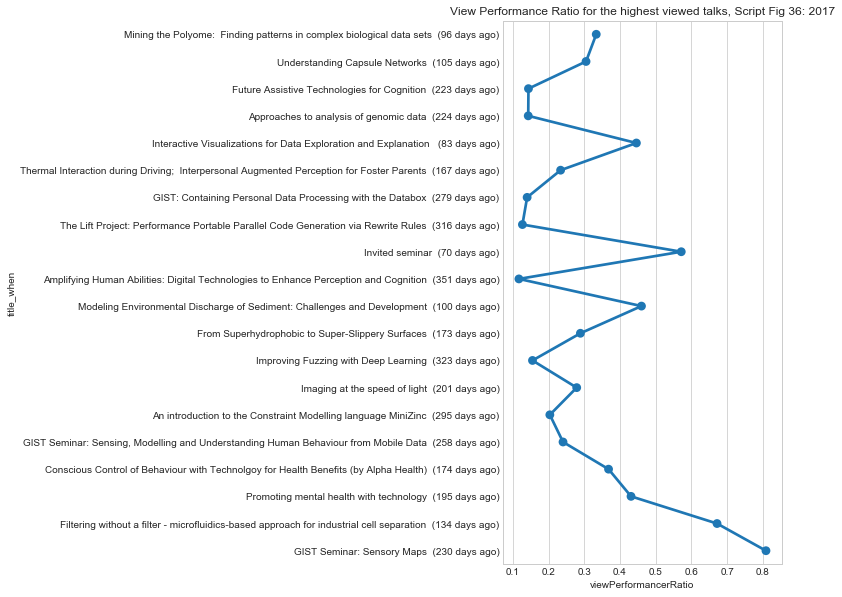

In [124]:
#Check for the view performance ratio

plt.subplots(figsize=(5, 10))

plt.title("View Performance Ratio for the highest viewed talks, Script Fig 36: "  +str(year_entered))

ax = sns.pointplot(x="viewPerformancerRatio", y="title_when", data=talkview_details)


# Get current axis on current figure
ax = plt.gca()




In [125]:
#Review Series details again, where number of views is greater than 30

seriestalk_details =seriestalk_details[seriestalk_details['total']>70]

seriestalk_details.head()

,referer,total,seriesIDRef,title
seriesID,,,,
20,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,76,20,College of Social Sciences
4,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,96,4,Computer Vision for Autonomous Systems (CVAS)
21,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,99,21,Deep learning reading group
76,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,104,76,The Data Lab
48,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,110,48,Infrastructure and Environment


# [10.1] The talk series pages with the highest views this academic year 

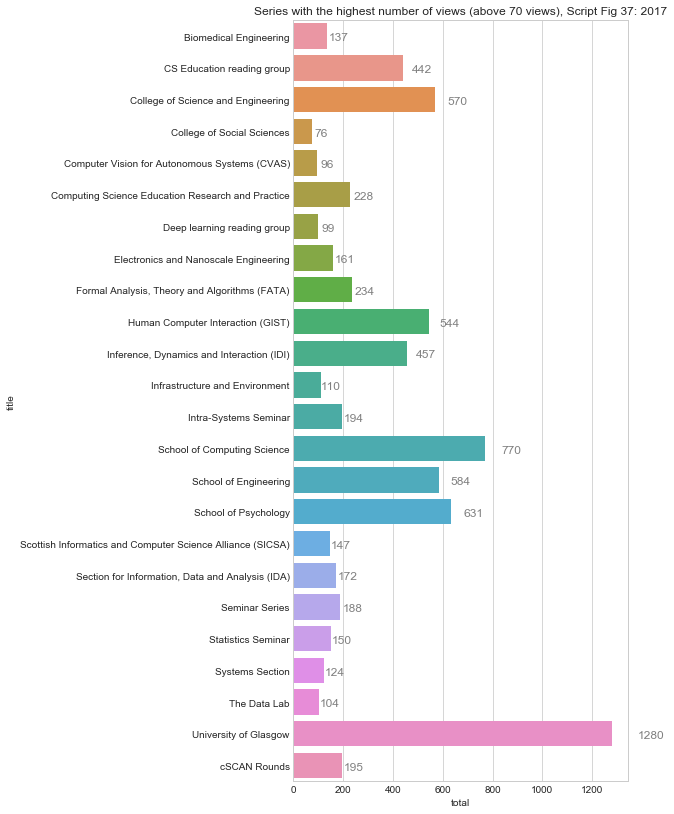

In [126]:
# [10.1] The talk series pages with the highest views this academic year 
    
data = seriestalk_details.sort_values('title',ascending=True)

plt.subplots(figsize=(6, 14))

plt.title("Series with the highest number of views (above 70 views), Script Fig 37: "  +str(year_entered))

g = sns.barplot( y='title', x="total"  , data=data)

# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    if p.get_width()> 0:
        ax.text(30+ p.get_width()+ p.get_width()*0.1,p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
            fontsize=12, color='grey', ha='center', va="center", rotation="-0")
    

In [127]:
#Review talk head again
talkview_details.head()

,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU,when,title_when,viewPerformancerRatio
talkID,,,,,,,,,,,,
8910,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8910,Mining the Polyome: Finding patterns in compl...,2018-05-25 13:00:00,University of Glasgow,internal,96,3,(96 days ago),Mining the Polyome: Finding patterns in compl...,0.333333
9017,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,9017,Understanding Capsule Networks,2018-05-16 12:00:00,"Computer Vision and Autonomous Group, School o...",internal,105,4,(105 days ago),Understanding Capsule Networks (105 days ago),0.304762
8694,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8694,Future Assistive Technologies for Cognition,2018-01-18 13:00:00,University of Glasgow,internal,223,7,(223 days ago),Future Assistive Technologies for Cognition (...,0.143498
8791,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8791,Approaches to analysis of genomic data,2018-01-17 12:00:00,University of Glasgow,internal,224,8,(224 days ago),Approaches to analysis of genomic data (224 d...,0.142857
8867,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,37,8867,Interactive Visualizations for Data Exploratio...,2018-06-07 12:00:00,University of Edinburgh,external,83,7,(83 days ago),Interactive Visualizations for Data Exploratio...,0.445783


In [128]:
#And review the series table 
seriestalk_details.head()

,referer,total,seriesIDRef,title
seriesID,,,,
20,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,76,20,College of Social Sciences
4,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,96,4,Computer Vision for Autonomous Systems (CVAS)
21,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,99,21,Deep learning reading group
76,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,104,76,The Data Lab
48,https://samoa.dcs.gla.ac.uk/events/series.jsp?...,110,48,Infrastructure and Environment


In [129]:
#Let's get the table that connects the view table to the series table

#We want to load the SQL data for talk, organisational group and location in CSV

#a_details  = pd.read_csv('viewtalkcount.csv', sep =';')

#Now let's open the talk_details in a dataFrame

talkview_details = DataFrame(talkview_details)

talkview_details.head()

,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU,when,title_when,viewPerformancerRatio
talkID,,,,,,,,,,,,
8910,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8910,Mining the Polyome: Finding patterns in compl...,2018-05-25 13:00:00,University of Glasgow,internal,96,3,(96 days ago),Mining the Polyome: Finding patterns in compl...,0.333333
9017,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,9017,Understanding Capsule Networks,2018-05-16 12:00:00,"Computer Vision and Autonomous Group, School o...",internal,105,4,(105 days ago),Understanding Capsule Networks (105 days ago),0.304762
8694,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8694,Future Assistive Technologies for Cognition,2018-01-18 13:00:00,University of Glasgow,internal,223,7,(223 days ago),Future Assistive Technologies for Cognition (...,0.143498
8791,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8791,Approaches to analysis of genomic data,2018-01-17 12:00:00,University of Glasgow,internal,224,8,(224 days ago),Approaches to analysis of genomic data (224 d...,0.142857
8867,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,37,8867,Interactive Visualizations for Data Exploratio...,2018-06-07 12:00:00,University of Edinburgh,external,83,7,(83 days ago),Interactive Visualizations for Data Exploratio...,0.445783


In [130]:
#Let's add the series total number of views and the series new to the talkview_details table

def addOUTitle(alltalks):
    for a in alltalks[0:]:
        for b in seriestalk_details['seriesIDRef'][0:]:
            try:
                if int(a) == int(b):
                    a = int(a)
                    return(seriestalk_details.loc[b]['title'])
            except:
                    return('No valid data...')

def __str__(alltalks):
    for a in alltalks[0:]:
        for b in seriestalk_details['seriesIDRef'][0:]:
            try:
                if int(a) == int(b):
                    a = int(a)
                    return(str(seriestalk_details.loc[b]['total']))
            except:
                    return('No valid data...')
                
def addOUTotal(alltalks):
    for a in alltalks[0:]:
        for b in seriestalk_details['seriesIDRef'][0:]:
            try:
                if int(a) == int(b):
                    a = int(a)
                    return(seriestalk_details.loc[b]['total'])
            except:
                    return('No valid data...')


In [131]:
talkview_details['OUTitle'] = talkview_details[['owingOU']].apply(addOUTitle,axis=1)

talkview_details['seriesViewTotal'] = talkview_details[['owingOU']].apply(__str__,axis=1)

talkview_details['seriesViewTotalInt'] = talkview_details[['owingOU']].apply(addOUTotal,axis=1)

talkview_details.head()

,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU,when,title_when,viewPerformancerRatio,OUTitle,seriesViewTotal,seriesViewTotalInt
talkID,,,,,,,,,,,,,,,
8910,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8910,Mining the Polyome: Finding patterns in compl...,2018-05-25 13:00:00,University of Glasgow,internal,96,3,(96 days ago),Mining the Polyome: Finding patterns in compl...,0.333333,School of Computing Science,770,770
9017,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,9017,Understanding Capsule Networks,2018-05-16 12:00:00,"Computer Vision and Autonomous Group, School o...",internal,105,4,(105 days ago),Understanding Capsule Networks (105 days ago),0.304762,Computer Vision for Autonomous Systems (CVAS),96,96
8694,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8694,Future Assistive Technologies for Cognition,2018-01-18 13:00:00,University of Glasgow,internal,223,7,(223 days ago),Future Assistive Technologies for Cognition (...,0.143498,Human Computer Interaction (GIST),544,544
8791,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8791,Approaches to analysis of genomic data,2018-01-17 12:00:00,University of Glasgow,internal,224,8,(224 days ago),Approaches to analysis of genomic data (224 d...,0.142857,"Inference, Dynamics and Interaction (IDI)",457,457
8867,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,37,8867,Interactive Visualizations for Data Exploratio...,2018-06-07 12:00:00,University of Edinburgh,external,83,7,(83 days ago),Interactive Visualizations for Data Exploratio...,0.445783,Human Computer Interaction (GIST),544,544


In [132]:
#Let's now make the talk 
talkview_details['title_Series Views'] =talkview_details['title'] +' (Series views - '+talkview_details['seriesViewTotal'] +')'

talkview_details.head()


,referer,total,talkIDRef,title,starttime,speakerAffiliation,InternalExternalSpeaker,days_uploaded,owingOU,when,title_when,viewPerformancerRatio,OUTitle,seriesViewTotal,seriesViewTotalInt,title_Series Views
talkID,,,,,,,,,,,,,,,,
8910,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8910,Mining the Polyome: Finding patterns in compl...,2018-05-25 13:00:00,University of Glasgow,internal,96,3,(96 days ago),Mining the Polyome: Finding patterns in compl...,0.333333,School of Computing Science,770,770,Mining the Polyome: Finding patterns in compl...
9017,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,9017,Understanding Capsule Networks,2018-05-16 12:00:00,"Computer Vision and Autonomous Group, School o...",internal,105,4,(105 days ago),Understanding Capsule Networks (105 days ago),0.304762,Computer Vision for Autonomous Systems (CVAS),96,96,Understanding Capsule Networks (Series views -...
8694,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8694,Future Assistive Technologies for Cognition,2018-01-18 13:00:00,University of Glasgow,internal,223,7,(223 days ago),Future Assistive Technologies for Cognition (...,0.143498,Human Computer Interaction (GIST),544,544,Future Assistive Technologies for Cognition (S...
8791,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,32,8791,Approaches to analysis of genomic data,2018-01-17 12:00:00,University of Glasgow,internal,224,8,(224 days ago),Approaches to analysis of genomic data (224 d...,0.142857,"Inference, Dynamics and Interaction (IDI)",457,457,Approaches to analysis of genomic data (Series...
8867,https://samoa.dcs.gla.ac.uk/events/viewtalk.js...,37,8867,Interactive Visualizations for Data Exploratio...,2018-06-07 12:00:00,University of Edinburgh,external,83,7,(83 days ago),Interactive Visualizations for Data Exploratio...,0.445783,Human Computer Interaction (GIST),544,544,Interactive Visualizations for Data Exploratio...


In [133]:
#Plot series vs talk Performance Ratio for the highest viewed talks"
talkview_details['seriesViewPerformancerRatio'] = talkview_details['total'] /talkview_details['seriesViewTotalInt']

# [10.2] A comparison of the series views with their corresponding talk views 

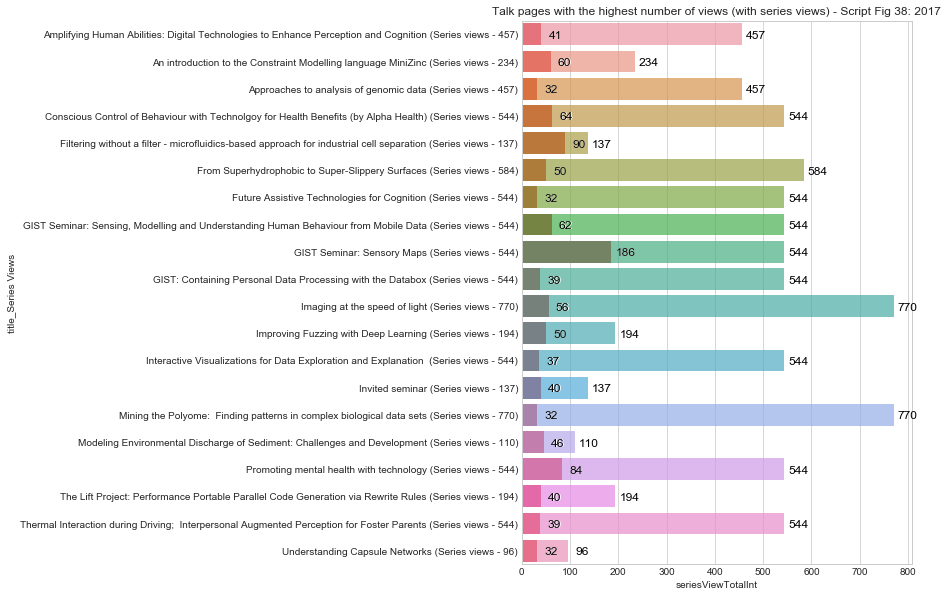

In [134]:
#Plotting the pages with the highest views where number of views is greater then 30times and compare them the series no. of views
# [10.2] A comparison of the series views with their corresponding talk views 
if data.empty:
    print('DataFrame is empty!')
else:
    data = talkview_details.sort_values('title_Series Views',ascending=True)

    plt.subplots(figsize=(7, 10))

    plt.title("Talk pages with the highest number of views (with series views) - Script Fig 38: "  +str(year_entered))

    g = sns.barplot( y='title_Series Views', x="total"  , data=data, color='red')

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width()> 0:
            ax.text( 30+p.get_width(),p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='white', ha='center', va="center")

if data.empty:
    print('DataFrame is empty!')
else:
    g = sns.barplot( y='title_Series Views', x="seriesViewTotalInt"  , data=data,  alpha=0.7)

    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_width()> 0:
            ax.text( 29+p.get_width(),p.get_y() + 0.55*p.get_height(), '%d' % int(p.get_width()), 
                fontsize=12, color='black', ha='center', va="center")


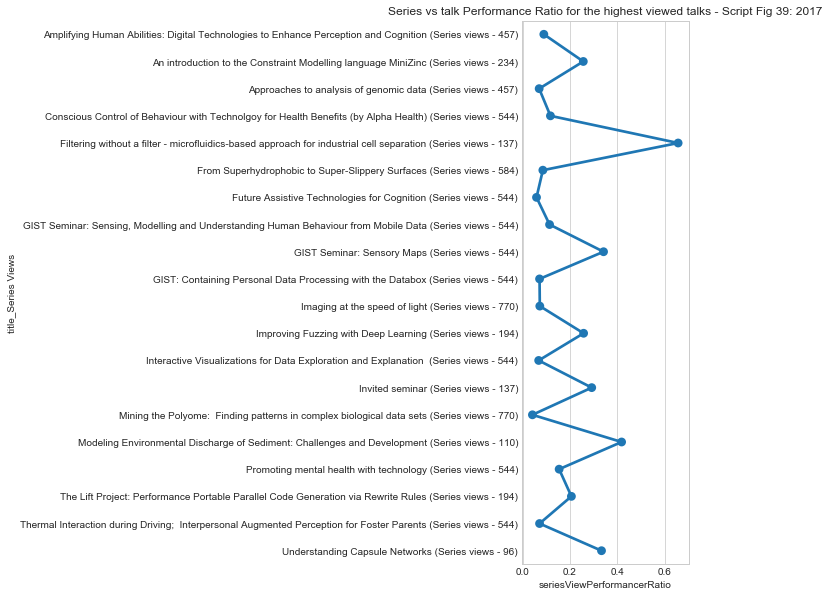

In [135]:
#"Series vs talk Performance Ratio for the highest viewed talks"
if data.empty:
    print('DataFrame is empty!')
else:
    plt.subplots(figsize=(3, 10))

    plt.title("Series vs talk Performance Ratio for the highest viewed talks - Script Fig 39: "  +str(year_entered))

    data = talkview_details.sort_values('title_Series Views',ascending=True)

    ax = sns.pointplot(x="seriesViewPerformancerRatio", y="title_Series Views", data=data)


    # Get current axis on current figure
    ax = plt.gca()

 

In [136]:
#Check for intruder activities

#GOD IS EXCELLENT

intruder=intruder[(intruder['remoteHost'] == ip_entered)]

intruder.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type
448318,194.81.63.4,905531,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448319,194.81.63.4,905532,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448320,194.81.63.4,905533,,None,2018-03-23 22:14:56,None,Front Page,/events/,Not Known,Not User Feed
448321,194.81.63.4,905534,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed
448322,194.81.63.4,905535,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed


In [137]:
#Import date library

import datetime
from datetime import datetime, timedelta

#So lets split the day and time to visualise intruder query distribution in days and in time

   #method to return actual date values
def days_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    return days 

    #method to return actual hour values
def hours_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    hour = int(theday[0][2][3:5])
      
    return hour



    #method to return actual hour values
def hourlabel_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    
    hour = int(theday[0][2][3:5])
    

    if hour >= 0 and hour <= 5:
        return '0-5am'
    elif hour >=6 and hour <=10:
        return "6-10am"
    elif hour >=11 and hour <=14:
        return "11am-2pm"
    elif hour >=15 and hour <=18:
        return "3pm-6pm"
    elif hour >=18 and hour <=24:
        return "6pm-12am"
    
    return hour

    #method to return actual month values
def months_Value (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
   
    month = int(theday[0][1])
        
    return month

#Method to get number of days and days description string
def defineDays (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
    year = int(theday[0][0])
    month = int(theday[0][1])
    day = int(theday[0][2][0:2])
    hour = int(theday[0][2][3:5])
    mins = int(theday[0][2][6:8])
    seconds = int(theday[0][2][9:11])

    #insert the dates into the datetime method
    a1 = datetime(year,month,day,hour,mins,seconds)

    a2 = datetime.now() - a1

    days = a2.days
    
    if days < 0:
        return ''
    elif days == 0:
        return "within 24 hours" 
    elif days > 0 and days < 7:
        return '1 to 7 days ago'
    elif days >=7 and days <30:
        return "7 to 30 days ago"
    elif days >=30 and days <60:
        return "1 to 2 months ago"
    elif days >=60 and days <120:
        return "2 to 4 months ago"
    elif days >=120 and days <180:
        return "4 to 6 months ago"
    elif days >=180 and days <365:
        return "6months to 1 year ago"

    #Method to get number of days and days description string
def semester (dateandtime):

    #dateandtime = talk_details['starttime']
    theday = dateandtime.str.split('-')
   
    month = int(theday[0][1])
    
    if month < 0:
        return ''
    elif month >=9 and month <= 12:
        return 'Semester 1'
    elif month >=1 and month <=4:
        return "Semester 2"
    elif month >=5 and month <=8:
        return "Semester 3"

In [138]:
#Column to show specific semester, day and time of the day
intruder['days_value'] = intruder[['timestamp']].apply(days_Value,axis=1)

intruder['month_value'] = intruder[['timestamp']].apply(months_Value,axis=1)

intruder['hour of the day'] = intruder[['timestamp']].apply(hours_Value,axis=1)

intruder['hour label'] = intruder[['timestamp']].apply(hourlabel_Value,axis=1)

intruder['period'] = intruder[['timestamp']].apply(defineDays,axis=1)

intruder['School Session'] = intruder[['timestamp']].apply(semester,axis=1)


In [139]:
intruder.head()

,remoteHost,id,userid,userName,timestamp,referer,query_type,query,user_status,queryFeed_type,days_value,month_value,hour of the day,hour label,period,School Session
448318,194.81.63.4,905531,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed,159,3,22,6pm-12am,4 to 6 months ago,Semester 2
448319,194.81.63.4,905532,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed,159,3,22,6pm-12am,4 to 6 months ago,Semester 2
448320,194.81.63.4,905533,,None,2018-03-23 22:14:56,None,Front Page,/events/,Not Known,Not User Feed,159,3,22,6pm-12am,4 to 6 months ago,Semester 2
448321,194.81.63.4,905534,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed,159,3,22,6pm-12am,4 to 6 months ago,Semester 2
448322,194.81.63.4,905535,,None,2018-03-23 22:14:56,None,Front Page,/events/index.jsp,Not Known,Not User Feed,159,3,22,6pm-12am,4 to 6 months ago,Semester 2


# [11] The IP Clinic check for potential intruder

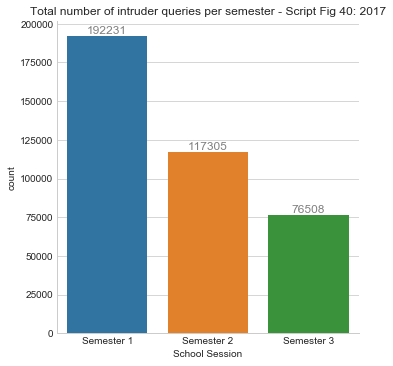

In [140]:
# [11] The total number of intruder (unwanted user) queries this academic year
if intruder.empty:
    print('DataFrame is empty!')
else:
    intruder = intruder.sort_values('timestamp',ascending=True)

    g = sns.factorplot( x="School Session" , 
                       data=intruder, kind="count", size=5
                      )

    plt.title("Total number of intruder queries per semester - Script Fig 40: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+50, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')


# [11.1] The amount of the different type of queries they sent this academic year

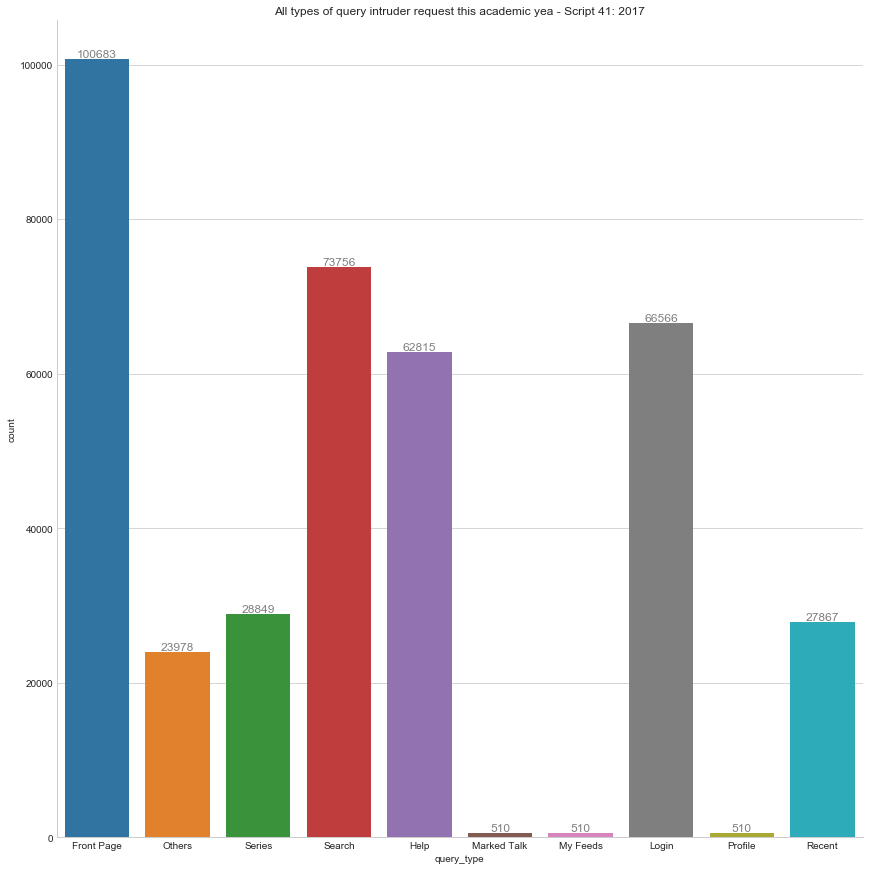

In [141]:
# [11.1] The amount of the different type of queries they sent this academic year
if intruder.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="query_type" , 
                       data=intruder, kind="count", size=12)


    plt.title("All types of query intruder request this academic yea - Script 41: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()
    #plt.ticks(rotation=89)

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+30, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')
    

# [11.2] All the queries for each semester this academic 

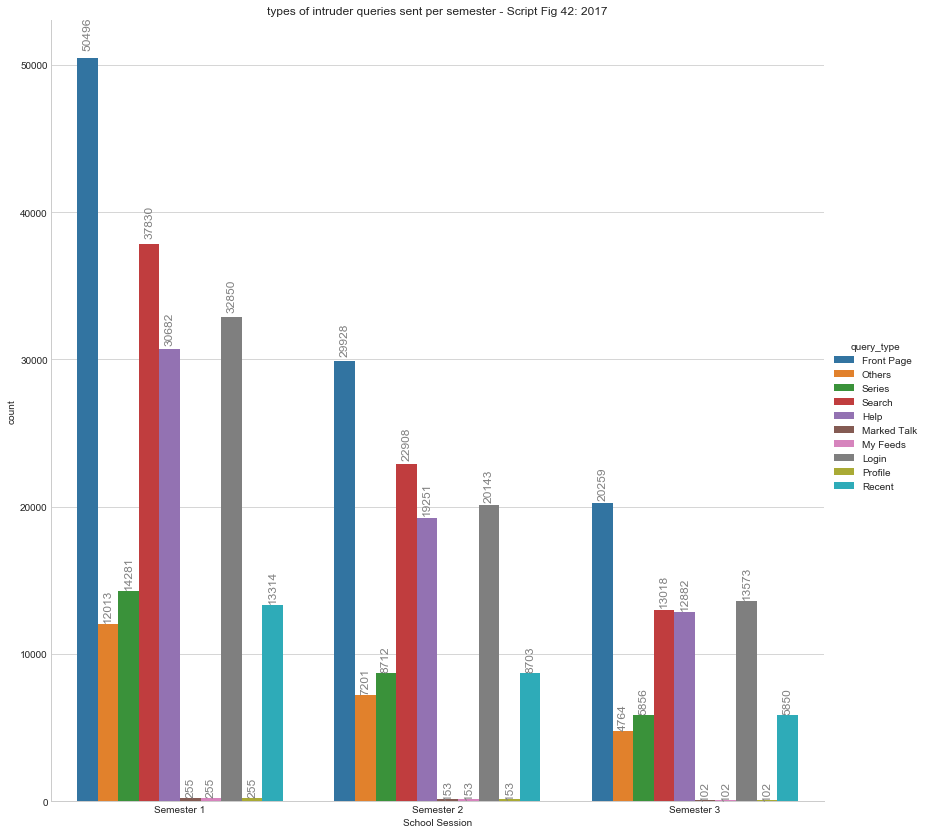

In [142]:
# [11.2] All the intruder queries for each semester this academic 
if intruder.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="School Session" , 
                       data=intruder, kind="count", size=11.5, hue='query_type')


    plt.title("types of intruder queries sent per semester - Script Fig 42: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom', rotation='90')

# [11.3] The time of day which their process is most active this academic year 


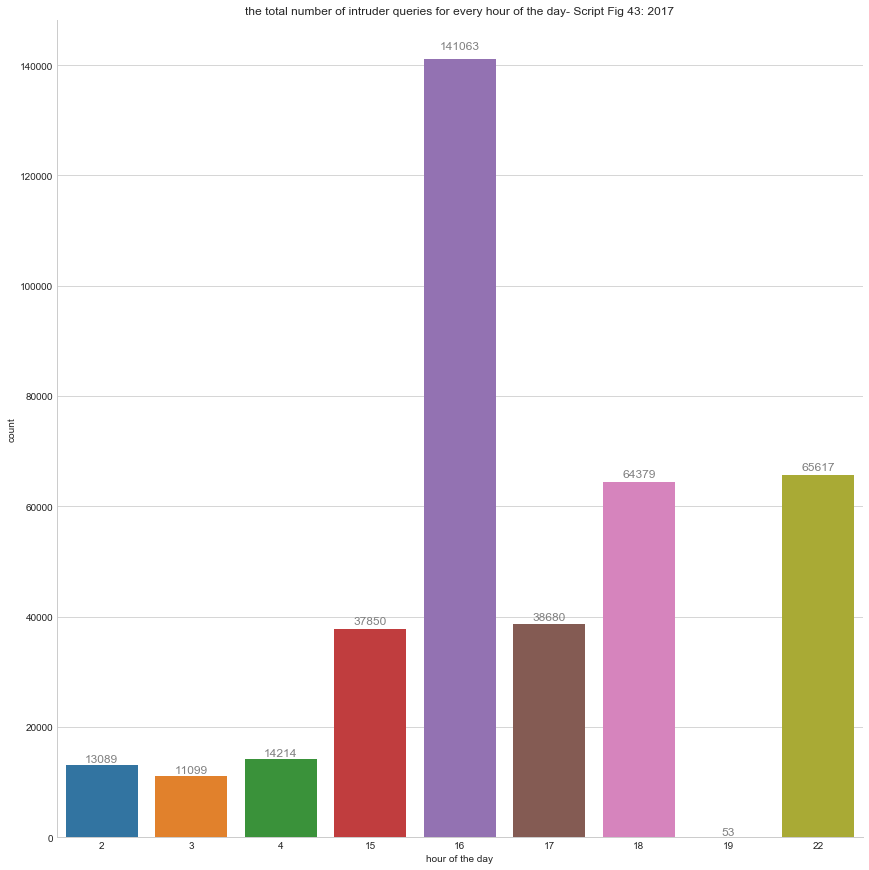

In [143]:
# [11.3] The time of day which their process is most active this academic year 
if intruder.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="hour of the day" , 
                       data=intruder, kind="count", size=12)

    plt.title("the total number of intruder queries for every hour of the day- Script Fig 43: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=12, color='grey', ha='center', va='bottom')

#  [11.4] A plot of the types of  query for a specific time group in a day 

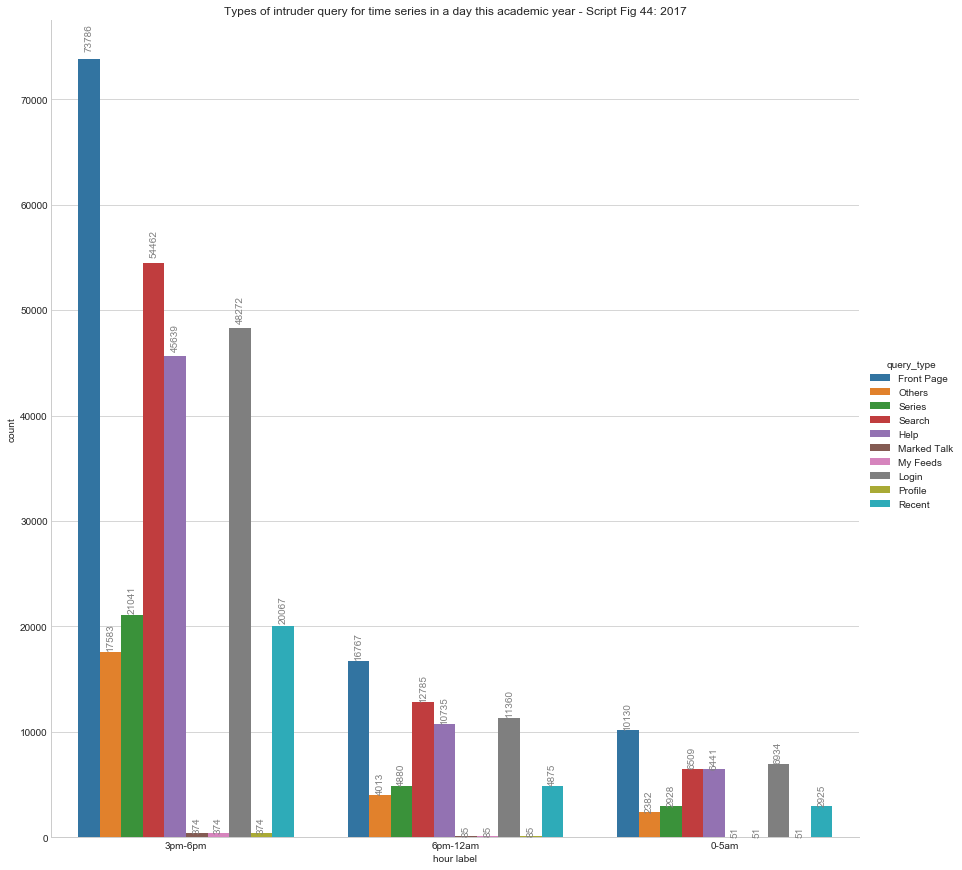

In [144]:
#  [11.4] A plot of the types of intruder query for time series in a day this academic year
if intruder.empty:
    print('DataFrame is empty!')
else:
    g = sns.factorplot( x="hour label" , 
                       data=intruder, kind="count", size=12, hue='query_type')

    plt.title("Types of intruder query for time series in a day this academic year - Script Fig 44: "  +str(year_entered))


    # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        if p.get_height()> 0:
            ax.text(p.get_x() + p.get_width()/2., p.get_height()+ p.get_height()*0.01, '%d' % int(p.get_height()), 
                fontsize=10, color='grey', ha='center', va='bottom', rotation='90')